# M2177.003100 Deep Learning <br> Assignment #4 Implementing Variational AutoEncoder - part1 MNIST data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Chaehun Shin, September 2020

In this notebook, you will learn how to implement Variational AutoEncoder (VAEs) <br>
The goal here is to build VAEs that draw a digit (MNIST data) <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Student_ID** as input argument. <br>
This will produce a zipped file called *[Your Student_ID].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Student_ID)

### Some helpful tutorials and references for assignment #4-1:
- [1] Pytorch official tutorials. [[link]](https://pytorch.org/tutorials/)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).
- [4] Doersch, Carl. "Tutorial on variational autoencoders." arXiv preprint arXiv:1606.05908 (2016).
- [5] Kingma, Diederik P., and Max Welling. "An Introduction to Variational Autoencoders." arXiv preprint arXiv:1906.02691 (2019).

## 0. Download and load MNIST datasets
The MNIST datasets will be downloaded into the 'data/mnist' directory. If you want to change the directory the data is saved in, change 'mnist_data_dir' with where you want. <br>

In [1]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as T

mnist_data_dir = './data/mnist'
dataset = MNIST(root=mnist_data_dir,
               transform=T.ToTensor(), train=True, download=True)
print(dataset.train_data.shape)
print(dataset.train_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


/home/jaekyungcho/anaconda3/envs/deep-learning-20/lib/python3.8/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/jaekyungcho/anaconda3/envs/deep-learning-20/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


## <a name="1"></a> 1. Building a network

In this section, you will implement neural networks for <br>
(1) encoder $q_\phi(z \mid x)$ to encode latent variable distribution from the image of the digit <br>
(2) decoder $p_\theta(x \mid z)$ to decode the image distribution of the digit from the sample of latent variable distribution.<br>
You can use some layer function implemented in **'torch.nn'** library (abbretivated as **nn**) or **'torch.nn.functional'** library (abbreviated as **F**) as you want.

Just write the code in whatever way you find most clear.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

It is time for an encoder. <br>
It takes img_data, img_dim(should be 28\*28\*1=784 here), latent_dim(dimension of the z).<br>
It should return parameters of the latent variable distribution with the dimension of latent_dim. <br>
Because we model the latent variable distribution as multivariate Gaussian, we can make the distribution with only mean and covariance matrix. Also as we model each dimension of the latent variable as independent, covariance matrix becomes a diagonal matrix and we need only latent_dim number of elements for covariance matrix. <br>
So we output 2 latent_dim dimension vectors from the encoder function implemented by neural network. **I recommend to use logvar not variance itself for stable training.**


Maybe you can use two neural networks for mean and logvar vectors. However **it is recommended to use only one neural network with two last branches.**<br>
For example, if you use 5 layer networks, first 4 layers are shared and there are two 5th layers each corresponding to mean and logvar.

In [3]:
class Encoder(nn.Module):
    def __init__(self, img_dim=784, latent_dim=30):
        super().__init__()
        ################ ToDo ################
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding = 1), # 32*28*28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride =2, padding = 1), # 64*14*14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=3, stride = 2, padding = 1), # 128*7*7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride = 2, padding = 1), # 256*4*4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(), # 2304
        )
        self.fc_mu = nn.Linear(in_features=4096, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=4096, out_features=latent_dim)
        
        
    def forward(self, imgs):
        ################ ToDo ################
        imgs = imgs.view(-1,1,28,28)
        x = self.conv(imgs)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar

Now, it's time for a decoder model. <br>
It takes sample of the latent variable distribution(z), latent_dim(dimension of the latent variable), and img_dim(28\*28\*1=784 here). It should return the reconstruction of the original image x_hat. <br>
Decoder models the likelihood distributions and in here, we model each pixel as Bernoulli distribution(So we use binary cross entropy as loss function). So **you should use the sigmoid function to make the output as probability in [0, 1]**

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=30, img_dim=784):
        super().__init__()
        ################ ToDo ################
        self.fc = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=4096),
        )
        self.fc2 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride = 2, padding = 1), # 128*7*7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride = 2, padding = 1, output_padding=1), # 64*14*14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride = 2, padding = 1, output_padding=1), # 32*28*28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding = 1), # 1*28*28
            nn.Sigmoid(),
            nn.Flatten()
        )
        
        
    def forward(self, z):
        ################ ToDo ################
        out = self.fc(z)
        out = out.view(-1,256,4,4)
        out = self.fc2(out)
        out = self.deconv(out)
        
        return out

Now, we construct the VAEs with encoder and decoder.<br>
This model rquires an implementation of reparameterization trick (which you need to implement) due to impossible differentiation of sampling.<br>

### Reparameterization trick can be implemented as follows.
Our Encoder outputs mean and variance of Guassian distrubiton as parameters of posterior distribution.<br>

1. We sample epsilon form standard normal distribution with the size of latent dimension. <br>
2. Then, we scale and shift epsilon by using variance and mean of posterior distrubiton.<br>

Because sampling is out of graph, gradient can be flowed from loss to encoder and decoder. So we can train all networks jointly as you see in the forward function.

If you want to sample from the VAEs, you just sample from the prior distribution and go trough the decoder, as you can see in the sample function implemented below.

In [5]:
class VAE(nn.Module):
    def __init__(self, img_dim=784, latent_dim=10):
        super().__init__()
        self.encoder = Encoder(img_dim, latent_dim)
        self.decoder = Decoder(latent_dim, img_dim)
        self.latent_dim = latent_dim
        
    def encode(self, imgs):
        mu, logvar = self.encoder(imgs)
        return mu, logvar
    
    def decode(self, z):
        recon_imgs = self.decoder(z)
        return recon_imgs
        
    def reparameterize(self, eps, mu, logvar):
        ################ ToDo ################
        return mu + eps*logvar
        
        
    def forward(self, imgs):
        mu, logvar = self.encode(imgs)
        eps = torch.randn_like(mu)
        z = self.reparameterize(eps, mu, logvar)
        recon_imgs = self.decode(z)
        return recon_imgs, mu, logvar
    
    def sample(self, num_samples=16):
        device = next(self.parameters()).device
        eps = torch.randn((num_samples, self.latent_dim)).to(device)
        gen_imgs = self.decode(eps)
        return gen_imgs        

## <a name="2"></a> 2. Build a main part and train

In this section, you will implement the main part (define the loss function in TODO part).
Feel free to set the hyperparmeters and fill in the main part.
Then run the code and check the model reconstructs a digit.
When you are done, run the following to check your implementations.

Be sure to define **batch size bigger than 16** (Because, we visualize 16 images per batch in training time). <br>
You must show **at least three generated images** (At the beginning of ,in the midway of, at the end of training).

In [6]:
# hyperparameter setting
img_dim=784
latent_dim=8

batch_size = 64 # it should be larger than 16
learning_rate = 1e-3
total_iter = 8000

log_freq = 10
viz_freq = 50

Iter: 00010/8000, Recon loss: 3924.5195, KL div loss: 117.4997, Total loss: 4042.0193
Iter: 00020/8000, Recon loss: 3278.1240, KL div loss: 114.0356, Total loss: 3392.1597
Iter: 00030/8000, Recon loss: 3042.5891, KL div loss: 175.6740, Total loss: 3218.2632
Iter: 00040/8000, Recon loss: 2273.0684, KL div loss: 152.7804, Total loss: 2425.8486
Iter: 00050/8000, Recon loss: 2283.8215, KL div loss: 191.6115, Total loss: 2475.4331


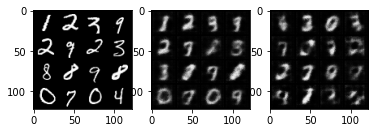

Iter: 00060/8000, Recon loss: 2146.8667, KL div loss: 160.7568, Total loss: 2307.6235
Iter: 00070/8000, Recon loss: 1860.6904, KL div loss: 173.3034, Total loss: 2033.9939
Iter: 00080/8000, Recon loss: 1886.2292, KL div loss: 164.7058, Total loss: 2050.9351
Iter: 00090/8000, Recon loss: 1809.4418, KL div loss: 177.6796, Total loss: 1987.1213
Iter: 00100/8000, Recon loss: 1914.9084, KL div loss: 155.1266, Total loss: 2070.0352


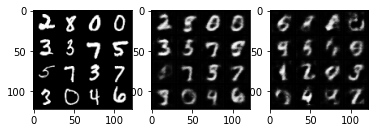

Iter: 00110/8000, Recon loss: 1862.0007, KL div loss: 150.0729, Total loss: 2012.0736
Iter: 00120/8000, Recon loss: 1804.4468, KL div loss: 196.2122, Total loss: 2000.6591
Iter: 00130/8000, Recon loss: 1707.5710, KL div loss: 161.7473, Total loss: 1869.3184
Iter: 00140/8000, Recon loss: 1681.2589, KL div loss: 157.0325, Total loss: 1838.2914
Iter: 00150/8000, Recon loss: 1666.3818, KL div loss: 164.0541, Total loss: 1830.4359


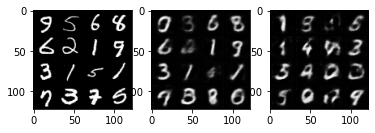

Iter: 00160/8000, Recon loss: 1560.0320, KL div loss: 159.4490, Total loss: 1719.4810
Iter: 00170/8000, Recon loss: 1438.6398, KL div loss: 177.3470, Total loss: 1615.9868
Iter: 00180/8000, Recon loss: 1541.4906, KL div loss: 181.1520, Total loss: 1722.6426
Iter: 00190/8000, Recon loss: 1676.6603, KL div loss: 161.2990, Total loss: 1837.9592
Iter: 00200/8000, Recon loss: 1846.4060, KL div loss: 190.1165, Total loss: 2036.5225


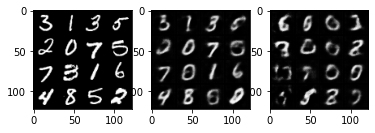

Iter: 00210/8000, Recon loss: 1613.5110, KL div loss: 141.1137, Total loss: 1754.6246
Iter: 00220/8000, Recon loss: 1408.0005, KL div loss: 153.5156, Total loss: 1561.5161
Iter: 00230/8000, Recon loss: 1553.0002, KL div loss: 151.7672, Total loss: 1704.7675
Iter: 00240/8000, Recon loss: 1659.5631, KL div loss: 141.0769, Total loss: 1800.6400
Iter: 00250/8000, Recon loss: 1620.9766, KL div loss: 165.7209, Total loss: 1786.6975


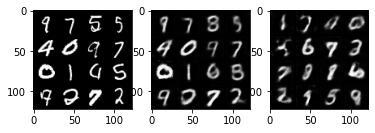

Iter: 00260/8000, Recon loss: 1514.1499, KL div loss: 146.1040, Total loss: 1660.2539
Iter: 00270/8000, Recon loss: 1559.1725, KL div loss: 153.4899, Total loss: 1712.6624
Iter: 00280/8000, Recon loss: 1440.6077, KL div loss: 146.8184, Total loss: 1587.4260
Iter: 00290/8000, Recon loss: 1552.2612, KL div loss: 165.6562, Total loss: 1717.9174
Iter: 00300/8000, Recon loss: 1581.9006, KL div loss: 182.7994, Total loss: 1764.7001


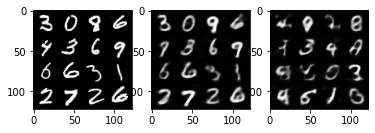

Iter: 00310/8000, Recon loss: 1499.9476, KL div loss: 175.8333, Total loss: 1675.7810
Iter: 00320/8000, Recon loss: 1521.5530, KL div loss: 145.3701, Total loss: 1666.9231
Iter: 00330/8000, Recon loss: 1469.8772, KL div loss: 135.6482, Total loss: 1605.5254
Iter: 00340/8000, Recon loss: 1562.4380, KL div loss: 118.3945, Total loss: 1680.8324
Iter: 00350/8000, Recon loss: 1464.1343, KL div loss: 224.2854, Total loss: 1688.4197


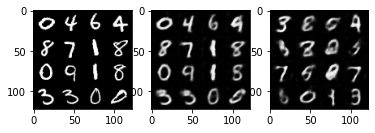

Iter: 00360/8000, Recon loss: 1426.3862, KL div loss: 155.2274, Total loss: 1581.6136
Iter: 00370/8000, Recon loss: 1384.5121, KL div loss: 161.5574, Total loss: 1546.0696
Iter: 00380/8000, Recon loss: 1379.9379, KL div loss: 146.6444, Total loss: 1526.5823
Iter: 00390/8000, Recon loss: 1405.0071, KL div loss: 145.8615, Total loss: 1550.8685
Iter: 00400/8000, Recon loss: 1275.2759, KL div loss: 156.7013, Total loss: 1431.9772


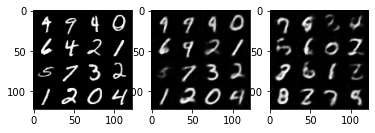

Iter: 00410/8000, Recon loss: 1536.1703, KL div loss: 144.3036, Total loss: 1680.4739
Iter: 00420/8000, Recon loss: 1341.3669, KL div loss: 137.6888, Total loss: 1479.0557
Iter: 00430/8000, Recon loss: 1340.3948, KL div loss: 119.4208, Total loss: 1459.8156
Iter: 00440/8000, Recon loss: 1366.0640, KL div loss: 134.4003, Total loss: 1500.4644
Iter: 00450/8000, Recon loss: 1202.8230, KL div loss: 117.1506, Total loss: 1319.9736


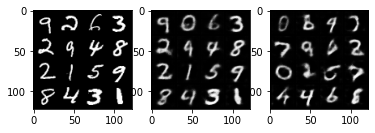

Iter: 00460/8000, Recon loss: 1395.3628, KL div loss: 109.8758, Total loss: 1505.2386
Iter: 00470/8000, Recon loss: 1303.9078, KL div loss: 125.0720, Total loss: 1428.9797
Iter: 00480/8000, Recon loss: 1319.5299, KL div loss: 110.4211, Total loss: 1429.9510
Iter: 00490/8000, Recon loss: 1280.8761, KL div loss: 126.5452, Total loss: 1407.4214
Iter: 00500/8000, Recon loss: 1183.0690, KL div loss: 96.3848, Total loss: 1279.4539


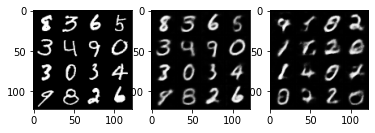

Iter: 00510/8000, Recon loss: 1380.6670, KL div loss: 137.2699, Total loss: 1517.9369
Iter: 00520/8000, Recon loss: 1380.9916, KL div loss: 136.9962, Total loss: 1517.9878
Iter: 00530/8000, Recon loss: 1316.0800, KL div loss: 142.5716, Total loss: 1458.6516
Iter: 00540/8000, Recon loss: 1303.5896, KL div loss: 143.9469, Total loss: 1447.5365
Iter: 00550/8000, Recon loss: 1308.8977, KL div loss: 104.1344, Total loss: 1413.0321


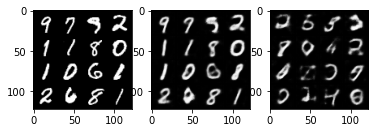

Iter: 00560/8000, Recon loss: 1262.2573, KL div loss: 89.4803, Total loss: 1351.7375
Iter: 00570/8000, Recon loss: 1156.8595, KL div loss: 93.6571, Total loss: 1250.5166
Iter: 00580/8000, Recon loss: 1265.9395, KL div loss: 120.7323, Total loss: 1386.6718
Iter: 00590/8000, Recon loss: 1463.3081, KL div loss: 119.1041, Total loss: 1582.4122
Iter: 00600/8000, Recon loss: 1426.5259, KL div loss: 107.2269, Total loss: 1533.7528


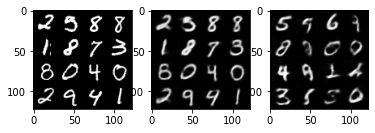

Iter: 00610/8000, Recon loss: 1221.9619, KL div loss: 126.9327, Total loss: 1348.8947
Iter: 00620/8000, Recon loss: 1260.2120, KL div loss: 97.8835, Total loss: 1358.0956
Iter: 00630/8000, Recon loss: 1307.5267, KL div loss: 113.5133, Total loss: 1421.0400
Iter: 00640/8000, Recon loss: 1168.7356, KL div loss: 130.1200, Total loss: 1298.8556
Iter: 00650/8000, Recon loss: 1160.2644, KL div loss: 119.0494, Total loss: 1279.3137


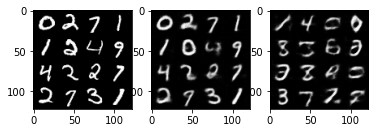

Iter: 00660/8000, Recon loss: 1286.1028, KL div loss: 127.5937, Total loss: 1413.6964
Iter: 00670/8000, Recon loss: 1112.1729, KL div loss: 142.2830, Total loss: 1254.4558
Iter: 00680/8000, Recon loss: 1480.5675, KL div loss: 137.0153, Total loss: 1617.5828
Iter: 00690/8000, Recon loss: 1157.5341, KL div loss: 125.7817, Total loss: 1283.3157
Iter: 00700/8000, Recon loss: 1129.4893, KL div loss: 134.0308, Total loss: 1263.5200


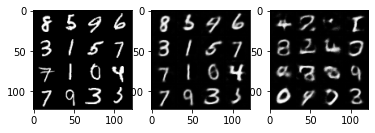

Iter: 00710/8000, Recon loss: 1161.4041, KL div loss: 91.1232, Total loss: 1252.5273
Iter: 00720/8000, Recon loss: 1233.4768, KL div loss: 149.7801, Total loss: 1383.2568
Iter: 00730/8000, Recon loss: 1299.7195, KL div loss: 139.4550, Total loss: 1439.1746
Iter: 00740/8000, Recon loss: 1160.8416, KL div loss: 117.0499, Total loss: 1277.8914
Iter: 00750/8000, Recon loss: 1199.7693, KL div loss: 115.4221, Total loss: 1315.1914


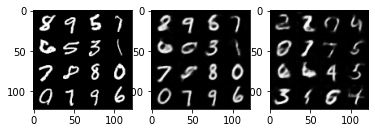

Iter: 00760/8000, Recon loss: 1173.7415, KL div loss: 99.4146, Total loss: 1273.1560
Iter: 00770/8000, Recon loss: 1291.9788, KL div loss: 99.9737, Total loss: 1391.9525
Iter: 00780/8000, Recon loss: 1154.0530, KL div loss: 117.6615, Total loss: 1271.7145
Iter: 00790/8000, Recon loss: 1135.5704, KL div loss: 113.3303, Total loss: 1248.9008
Iter: 00800/8000, Recon loss: 1191.0062, KL div loss: 78.7318, Total loss: 1269.7380


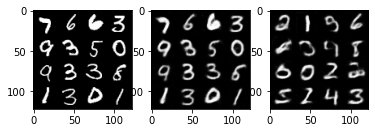

Iter: 00810/8000, Recon loss: 1062.9675, KL div loss: 78.6923, Total loss: 1141.6598
Iter: 00820/8000, Recon loss: 1107.1075, KL div loss: 114.6312, Total loss: 1221.7388
Iter: 00830/8000, Recon loss: 1179.6765, KL div loss: 123.0148, Total loss: 1302.6914
Iter: 00840/8000, Recon loss: 1173.5786, KL div loss: 116.0635, Total loss: 1289.6421
Iter: 00850/8000, Recon loss: 1216.9272, KL div loss: 104.2636, Total loss: 1321.1908


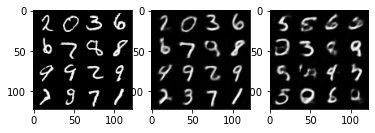

Iter: 00860/8000, Recon loss: 1174.3998, KL div loss: 100.3267, Total loss: 1274.7264
Iter: 00870/8000, Recon loss: 1129.6599, KL div loss: 98.3767, Total loss: 1228.0366
Iter: 00880/8000, Recon loss: 1063.6072, KL div loss: 112.0144, Total loss: 1175.6216
Iter: 00890/8000, Recon loss: 1071.6490, KL div loss: 84.6082, Total loss: 1156.2573
Iter: 00900/8000, Recon loss: 1066.2637, KL div loss: 113.2408, Total loss: 1179.5045


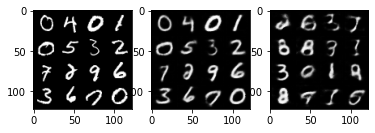

Iter: 00910/8000, Recon loss: 1025.5178, KL div loss: 101.6356, Total loss: 1127.1533
Iter: 00920/8000, Recon loss: 1179.4795, KL div loss: 89.1837, Total loss: 1268.6631
Iter: 00930/8000, Recon loss: 894.2536, KL div loss: 88.3867, Total loss: 982.6404
Iter: 00940/8000, Recon loss: 1099.7795, KL div loss: 89.6698, Total loss: 1189.4493
Iter: 00950/8000, Recon loss: 1179.3140, KL div loss: 114.0316, Total loss: 1293.3456


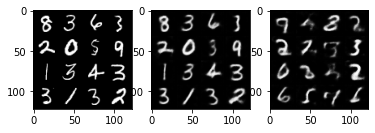

Iter: 00960/8000, Recon loss: 1047.1660, KL div loss: 90.7794, Total loss: 1137.9454
Iter: 00970/8000, Recon loss: 1046.2657, KL div loss: 97.3916, Total loss: 1143.6573
Iter: 00980/8000, Recon loss: 1035.2908, KL div loss: 68.3976, Total loss: 1103.6884
Iter: 00990/8000, Recon loss: 1191.7928, KL div loss: 101.0351, Total loss: 1292.8280
Iter: 01000/8000, Recon loss: 983.5007, KL div loss: 110.8413, Total loss: 1094.3420


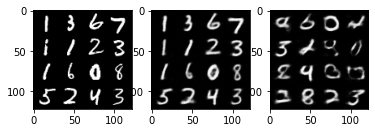

Iter: 01010/8000, Recon loss: 1114.6855, KL div loss: 85.7536, Total loss: 1200.4392
Iter: 01020/8000, Recon loss: 1079.4735, KL div loss: 120.2143, Total loss: 1199.6879
Iter: 01030/8000, Recon loss: 983.6172, KL div loss: 109.8217, Total loss: 1093.4390
Iter: 01040/8000, Recon loss: 1266.2222, KL div loss: 68.2398, Total loss: 1334.4619
Iter: 01050/8000, Recon loss: 1044.1396, KL div loss: 84.6279, Total loss: 1128.7676


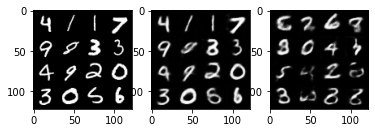

Iter: 01060/8000, Recon loss: 1084.8408, KL div loss: 75.5594, Total loss: 1160.4001
Iter: 01070/8000, Recon loss: 1019.1293, KL div loss: 101.0252, Total loss: 1120.1544
Iter: 01080/8000, Recon loss: 1096.7888, KL div loss: 86.1658, Total loss: 1182.9546
Iter: 01090/8000, Recon loss: 1016.4376, KL div loss: 76.2450, Total loss: 1092.6825
Iter: 01100/8000, Recon loss: 949.0112, KL div loss: 58.3330, Total loss: 1007.3441


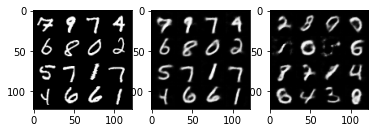

Iter: 01110/8000, Recon loss: 1028.3114, KL div loss: 67.0623, Total loss: 1095.3737
Iter: 01120/8000, Recon loss: 1113.4089, KL div loss: 78.7164, Total loss: 1192.1254
Iter: 01130/8000, Recon loss: 1023.6136, KL div loss: 52.3623, Total loss: 1075.9760
Iter: 01140/8000, Recon loss: 942.7497, KL div loss: 71.8610, Total loss: 1014.6107
Iter: 01150/8000, Recon loss: 1080.7107, KL div loss: 62.4220, Total loss: 1143.1327


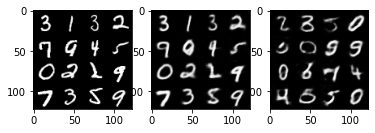

Iter: 01160/8000, Recon loss: 1049.6024, KL div loss: 94.5933, Total loss: 1144.1958
Iter: 01170/8000, Recon loss: 1030.8462, KL div loss: 79.5841, Total loss: 1110.4303
Iter: 01180/8000, Recon loss: 996.5823, KL div loss: 73.5842, Total loss: 1070.1665
Iter: 01190/8000, Recon loss: 1087.7913, KL div loss: 88.3993, Total loss: 1176.1906
Iter: 01200/8000, Recon loss: 1057.3365, KL div loss: 79.4217, Total loss: 1136.7583


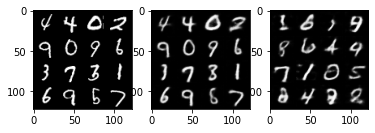

Iter: 01210/8000, Recon loss: 1051.4663, KL div loss: 80.6048, Total loss: 1132.0712
Iter: 01220/8000, Recon loss: 1008.9349, KL div loss: 64.3497, Total loss: 1073.2847
Iter: 01230/8000, Recon loss: 1095.5011, KL div loss: 51.9712, Total loss: 1147.4723
Iter: 01240/8000, Recon loss: 929.9656, KL div loss: 71.8521, Total loss: 1001.8177
Iter: 01250/8000, Recon loss: 1117.7821, KL div loss: 84.2667, Total loss: 1202.0488


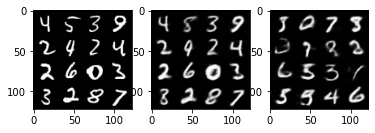

Iter: 01260/8000, Recon loss: 1125.5057, KL div loss: 88.2577, Total loss: 1213.7634
Iter: 01270/8000, Recon loss: 1035.6702, KL div loss: 89.2665, Total loss: 1124.9366
Iter: 01280/8000, Recon loss: 930.3035, KL div loss: 79.9871, Total loss: 1010.2905
Iter: 01290/8000, Recon loss: 968.4183, KL div loss: 76.6907, Total loss: 1045.1090
Iter: 01300/8000, Recon loss: 1037.2095, KL div loss: 106.6704, Total loss: 1143.8799


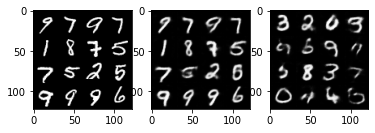

Iter: 01310/8000, Recon loss: 1124.7035, KL div loss: 57.4181, Total loss: 1182.1216
Iter: 01320/8000, Recon loss: 1013.0768, KL div loss: 91.8090, Total loss: 1104.8857
Iter: 01330/8000, Recon loss: 1000.8896, KL div loss: 62.9899, Total loss: 1063.8795
Iter: 01340/8000, Recon loss: 1015.4387, KL div loss: 54.8739, Total loss: 1070.3126
Iter: 01350/8000, Recon loss: 978.2758, KL div loss: 62.9248, Total loss: 1041.2006


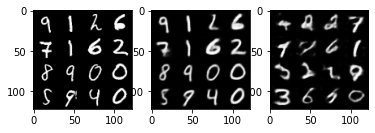

Iter: 01360/8000, Recon loss: 1079.3655, KL div loss: 84.4483, Total loss: 1163.8137
Iter: 01370/8000, Recon loss: 969.1270, KL div loss: 73.5099, Total loss: 1042.6368
Iter: 01380/8000, Recon loss: 1000.6420, KL div loss: 54.6398, Total loss: 1055.2817
Iter: 01390/8000, Recon loss: 1131.2012, KL div loss: 66.7916, Total loss: 1197.9928
Iter: 01400/8000, Recon loss: 1091.7234, KL div loss: 57.8150, Total loss: 1149.5385


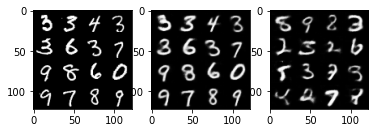

Iter: 01410/8000, Recon loss: 1075.0059, KL div loss: 95.1560, Total loss: 1170.1619
Iter: 01420/8000, Recon loss: 990.7992, KL div loss: 51.4951, Total loss: 1042.2943
Iter: 01430/8000, Recon loss: 956.0693, KL div loss: 56.9107, Total loss: 1012.9800
Iter: 01440/8000, Recon loss: 1048.6105, KL div loss: 81.2682, Total loss: 1129.8787
Iter: 01450/8000, Recon loss: 1081.5670, KL div loss: 66.5837, Total loss: 1148.1508


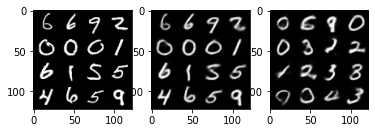

Iter: 01460/8000, Recon loss: 972.1722, KL div loss: 63.5044, Total loss: 1035.6766
Iter: 01470/8000, Recon loss: 1077.8807, KL div loss: 69.2102, Total loss: 1147.0909
Iter: 01480/8000, Recon loss: 939.5997, KL div loss: 76.1165, Total loss: 1015.7162
Iter: 01490/8000, Recon loss: 996.2837, KL div loss: 57.4579, Total loss: 1053.7416
Iter: 01500/8000, Recon loss: 1003.4134, KL div loss: 48.5970, Total loss: 1052.0104


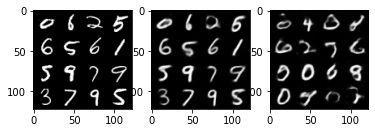

Iter: 01510/8000, Recon loss: 937.6329, KL div loss: 65.9889, Total loss: 1003.6219
Iter: 01520/8000, Recon loss: 1055.1946, KL div loss: 45.3031, Total loss: 1100.4977
Iter: 01530/8000, Recon loss: 1047.3621, KL div loss: 77.5476, Total loss: 1124.9097
Iter: 01540/8000, Recon loss: 965.6016, KL div loss: 58.5408, Total loss: 1024.1425
Iter: 01550/8000, Recon loss: 1135.4648, KL div loss: 54.5022, Total loss: 1189.9670


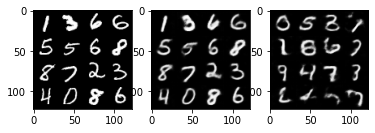

Iter: 01560/8000, Recon loss: 977.4598, KL div loss: 51.6462, Total loss: 1029.1060
Iter: 01570/8000, Recon loss: 1069.3323, KL div loss: 54.3845, Total loss: 1123.7167
Iter: 01580/8000, Recon loss: 922.7776, KL div loss: 47.7193, Total loss: 970.4969
Iter: 01590/8000, Recon loss: 874.4901, KL div loss: 72.8255, Total loss: 947.3156
Iter: 01600/8000, Recon loss: 892.8386, KL div loss: 44.5783, Total loss: 937.4169


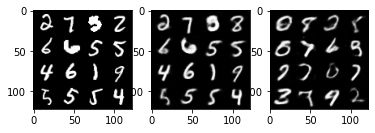

Iter: 01610/8000, Recon loss: 975.7335, KL div loss: 55.9682, Total loss: 1031.7017
Iter: 01620/8000, Recon loss: 963.1135, KL div loss: 62.1105, Total loss: 1025.2241
Iter: 01630/8000, Recon loss: 982.4188, KL div loss: 49.1628, Total loss: 1031.5815
Iter: 01640/8000, Recon loss: 915.5803, KL div loss: 44.0578, Total loss: 959.6381
Iter: 01650/8000, Recon loss: 1016.0363, KL div loss: 62.7215, Total loss: 1078.7578


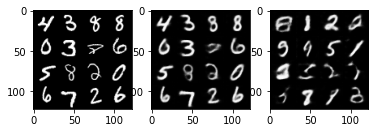

Iter: 01660/8000, Recon loss: 916.6764, KL div loss: 66.5508, Total loss: 983.2272
Iter: 01670/8000, Recon loss: 921.0443, KL div loss: 58.7029, Total loss: 979.7471
Iter: 01680/8000, Recon loss: 917.1316, KL div loss: 61.4314, Total loss: 978.5630
Iter: 01690/8000, Recon loss: 1038.4554, KL div loss: 76.4475, Total loss: 1114.9030
Iter: 01700/8000, Recon loss: 894.9077, KL div loss: 47.7891, Total loss: 942.6968


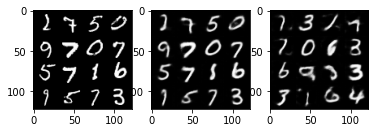

Iter: 01710/8000, Recon loss: 1064.0620, KL div loss: 73.9944, Total loss: 1138.0564
Iter: 01720/8000, Recon loss: 918.0094, KL div loss: 40.6931, Total loss: 958.7025
Iter: 01730/8000, Recon loss: 997.1521, KL div loss: 63.9225, Total loss: 1061.0746
Iter: 01740/8000, Recon loss: 996.5042, KL div loss: 51.1420, Total loss: 1047.6462
Iter: 01750/8000, Recon loss: 993.5781, KL div loss: 32.3994, Total loss: 1025.9775


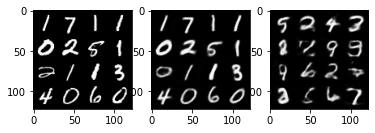

Iter: 01760/8000, Recon loss: 977.7050, KL div loss: 37.2178, Total loss: 1014.9228
Iter: 01770/8000, Recon loss: 892.3678, KL div loss: 49.9323, Total loss: 942.3001
Iter: 01780/8000, Recon loss: 842.3008, KL div loss: 38.4495, Total loss: 880.7503
Iter: 01790/8000, Recon loss: 1001.3186, KL div loss: 64.7674, Total loss: 1066.0861
Iter: 01800/8000, Recon loss: 926.5283, KL div loss: 51.5296, Total loss: 978.0578


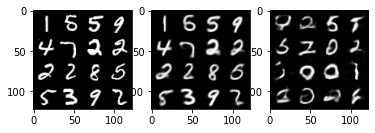

Iter: 01810/8000, Recon loss: 1001.8495, KL div loss: 40.1405, Total loss: 1041.9900
Iter: 01820/8000, Recon loss: 932.6124, KL div loss: 45.4498, Total loss: 978.0623
Iter: 01830/8000, Recon loss: 984.6912, KL div loss: 34.6790, Total loss: 1019.3701
Iter: 01840/8000, Recon loss: 896.9937, KL div loss: 41.4585, Total loss: 938.4522
Iter: 01850/8000, Recon loss: 946.6481, KL div loss: 45.7800, Total loss: 992.4282


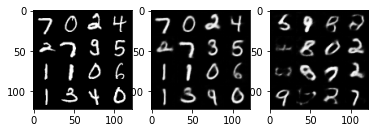

Iter: 01860/8000, Recon loss: 810.2898, KL div loss: 51.2095, Total loss: 861.4993
Iter: 01870/8000, Recon loss: 995.9058, KL div loss: 46.2225, Total loss: 1042.1283
Iter: 01880/8000, Recon loss: 924.1741, KL div loss: 52.6983, Total loss: 976.8723
Iter: 01890/8000, Recon loss: 874.7234, KL div loss: 42.3013, Total loss: 917.0247
Iter: 01900/8000, Recon loss: 983.6262, KL div loss: 38.6019, Total loss: 1022.2281


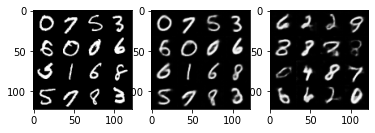

Iter: 01910/8000, Recon loss: 912.0829, KL div loss: 41.8229, Total loss: 953.9059
Iter: 01920/8000, Recon loss: 790.7944, KL div loss: 71.1973, Total loss: 861.9917
Iter: 01930/8000, Recon loss: 966.3640, KL div loss: 48.9943, Total loss: 1015.3583
Iter: 01940/8000, Recon loss: 931.9503, KL div loss: 36.4179, Total loss: 968.3683
Iter: 01950/8000, Recon loss: 948.6486, KL div loss: 48.3291, Total loss: 996.9777


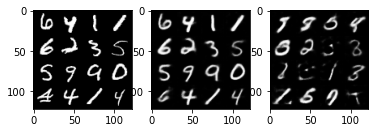

Iter: 01960/8000, Recon loss: 952.8008, KL div loss: 38.7095, Total loss: 991.5103
Iter: 01970/8000, Recon loss: 866.3254, KL div loss: 47.2276, Total loss: 913.5530
Iter: 01980/8000, Recon loss: 899.4927, KL div loss: 67.3103, Total loss: 966.8030
Iter: 01990/8000, Recon loss: 952.1039, KL div loss: 49.0654, Total loss: 1001.1693
Iter: 02000/8000, Recon loss: 797.4811, KL div loss: 40.3159, Total loss: 837.7971


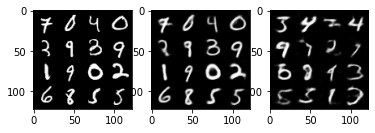

Iter: 02010/8000, Recon loss: 897.8192, KL div loss: 33.0469, Total loss: 930.8661
Iter: 02020/8000, Recon loss: 881.4308, KL div loss: 60.2467, Total loss: 941.6775
Iter: 02030/8000, Recon loss: 966.3724, KL div loss: 43.4801, Total loss: 1009.8525
Iter: 02040/8000, Recon loss: 863.9468, KL div loss: 32.0280, Total loss: 895.9748
Iter: 02050/8000, Recon loss: 855.2867, KL div loss: 31.4751, Total loss: 886.7618


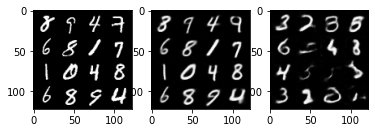

Iter: 02060/8000, Recon loss: 872.6252, KL div loss: 35.4021, Total loss: 908.0272
Iter: 02070/8000, Recon loss: 862.0336, KL div loss: 37.2622, Total loss: 899.2958
Iter: 02080/8000, Recon loss: 861.3371, KL div loss: 27.7885, Total loss: 889.1256
Iter: 02090/8000, Recon loss: 809.7016, KL div loss: 41.7360, Total loss: 851.4376
Iter: 02100/8000, Recon loss: 884.9368, KL div loss: 44.0066, Total loss: 928.9434


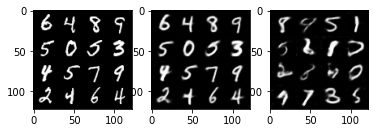

Iter: 02110/8000, Recon loss: 840.9033, KL div loss: 47.0522, Total loss: 887.9555
Iter: 02120/8000, Recon loss: 895.1426, KL div loss: 36.6018, Total loss: 931.7444
Iter: 02130/8000, Recon loss: 1000.6823, KL div loss: 41.1860, Total loss: 1041.8683
Iter: 02140/8000, Recon loss: 827.5259, KL div loss: 40.6994, Total loss: 868.2253
Iter: 02150/8000, Recon loss: 913.5000, KL div loss: 47.5926, Total loss: 961.0926


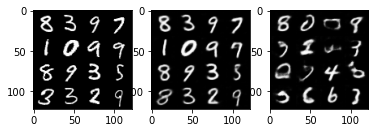

Iter: 02160/8000, Recon loss: 887.3462, KL div loss: 25.9745, Total loss: 913.3207
Iter: 02170/8000, Recon loss: 890.4242, KL div loss: 26.7948, Total loss: 917.2189
Iter: 02180/8000, Recon loss: 784.2073, KL div loss: 36.8877, Total loss: 821.0950
Iter: 02190/8000, Recon loss: 768.5364, KL div loss: 35.0656, Total loss: 803.6020
Iter: 02200/8000, Recon loss: 841.4828, KL div loss: 34.9627, Total loss: 876.4454


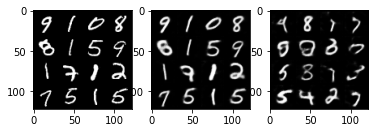

Iter: 02210/8000, Recon loss: 854.9235, KL div loss: 22.3501, Total loss: 877.2736
Iter: 02220/8000, Recon loss: 858.1199, KL div loss: 35.0790, Total loss: 893.1989
Iter: 02230/8000, Recon loss: 743.7574, KL div loss: 30.3528, Total loss: 774.1102
Iter: 02240/8000, Recon loss: 877.5544, KL div loss: 20.0610, Total loss: 897.6154
Iter: 02250/8000, Recon loss: 788.7631, KL div loss: 27.7071, Total loss: 816.4702


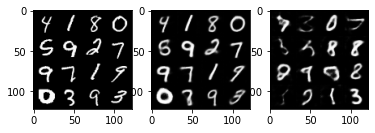

Iter: 02260/8000, Recon loss: 969.3344, KL div loss: 43.1224, Total loss: 1012.4568
Iter: 02270/8000, Recon loss: 856.4828, KL div loss: 28.7923, Total loss: 885.2751
Iter: 02280/8000, Recon loss: 823.5458, KL div loss: 21.8715, Total loss: 845.4173
Iter: 02290/8000, Recon loss: 777.4295, KL div loss: 35.6403, Total loss: 813.0698
Iter: 02300/8000, Recon loss: 768.2987, KL div loss: 25.4038, Total loss: 793.7025


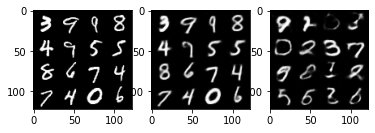

Iter: 02310/8000, Recon loss: 836.6158, KL div loss: 33.6561, Total loss: 870.2720
Iter: 02320/8000, Recon loss: 743.7454, KL div loss: 26.8657, Total loss: 770.6111
Iter: 02330/8000, Recon loss: 944.9948, KL div loss: 37.6505, Total loss: 982.6452
Iter: 02340/8000, Recon loss: 887.8837, KL div loss: 19.3278, Total loss: 907.2115
Iter: 02350/8000, Recon loss: 876.1664, KL div loss: 28.3748, Total loss: 904.5411


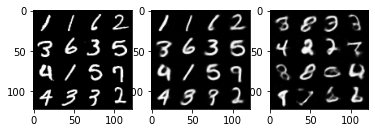

Iter: 02360/8000, Recon loss: 818.0947, KL div loss: 32.6635, Total loss: 850.7582
Iter: 02370/8000, Recon loss: 741.0775, KL div loss: 21.5621, Total loss: 762.6396
Iter: 02380/8000, Recon loss: 872.4109, KL div loss: 20.7464, Total loss: 893.1573
Iter: 02390/8000, Recon loss: 952.3101, KL div loss: 29.8899, Total loss: 982.2000
Iter: 02400/8000, Recon loss: 831.4844, KL div loss: 36.3153, Total loss: 867.7997


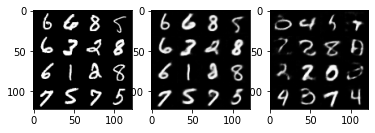

Iter: 02410/8000, Recon loss: 836.7861, KL div loss: 32.5551, Total loss: 869.3412
Iter: 02420/8000, Recon loss: 776.9252, KL div loss: 40.2406, Total loss: 817.1658
Iter: 02430/8000, Recon loss: 852.5041, KL div loss: 28.4135, Total loss: 880.9175
Iter: 02440/8000, Recon loss: 995.7648, KL div loss: 27.7965, Total loss: 1023.5612
Iter: 02450/8000, Recon loss: 904.7144, KL div loss: 37.0463, Total loss: 941.7607


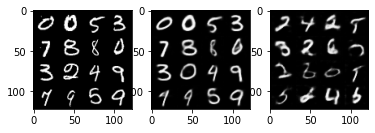

Iter: 02460/8000, Recon loss: 906.0850, KL div loss: 34.3966, Total loss: 940.4815
Iter: 02470/8000, Recon loss: 966.7123, KL div loss: 32.0902, Total loss: 998.8025
Iter: 02480/8000, Recon loss: 811.3683, KL div loss: 26.7711, Total loss: 838.1394
Iter: 02490/8000, Recon loss: 806.7855, KL div loss: 32.7863, Total loss: 839.5718
Iter: 02500/8000, Recon loss: 776.8301, KL div loss: 29.8183, Total loss: 806.6484


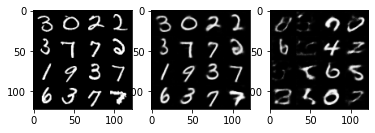

Iter: 02510/8000, Recon loss: 738.3419, KL div loss: 30.2053, Total loss: 768.5471
Iter: 02520/8000, Recon loss: 839.7872, KL div loss: 27.4288, Total loss: 867.2160
Iter: 02530/8000, Recon loss: 941.5338, KL div loss: 27.2300, Total loss: 968.7639
Iter: 02540/8000, Recon loss: 655.4330, KL div loss: 25.5306, Total loss: 680.9636
Iter: 02550/8000, Recon loss: 815.5388, KL div loss: 25.0161, Total loss: 840.5549


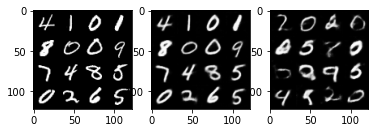

Iter: 02560/8000, Recon loss: 790.4694, KL div loss: 34.3265, Total loss: 824.7959
Iter: 02570/8000, Recon loss: 786.0499, KL div loss: 31.1223, Total loss: 817.1722
Iter: 02580/8000, Recon loss: 792.1638, KL div loss: 29.7120, Total loss: 821.8758
Iter: 02590/8000, Recon loss: 819.9385, KL div loss: 27.0441, Total loss: 846.9825
Iter: 02600/8000, Recon loss: 763.9958, KL div loss: 26.2301, Total loss: 790.2260


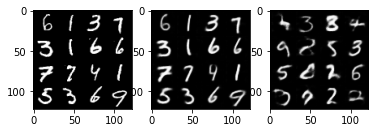

Iter: 02610/8000, Recon loss: 752.7052, KL div loss: 25.1831, Total loss: 777.8883
Iter: 02620/8000, Recon loss: 897.8535, KL div loss: 24.6323, Total loss: 922.4857
Iter: 02630/8000, Recon loss: 892.4891, KL div loss: 31.9279, Total loss: 924.4170
Iter: 02640/8000, Recon loss: 917.0458, KL div loss: 26.5925, Total loss: 943.6382
Iter: 02650/8000, Recon loss: 867.9882, KL div loss: 40.5266, Total loss: 908.5147


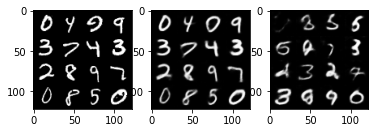

Iter: 02660/8000, Recon loss: 817.1644, KL div loss: 29.1444, Total loss: 846.3088
Iter: 02670/8000, Recon loss: 782.6952, KL div loss: 26.6747, Total loss: 809.3699
Iter: 02680/8000, Recon loss: 861.5114, KL div loss: 23.4458, Total loss: 884.9572
Iter: 02690/8000, Recon loss: 821.6258, KL div loss: 27.3584, Total loss: 848.9842
Iter: 02700/8000, Recon loss: 926.5990, KL div loss: 32.1987, Total loss: 958.7977


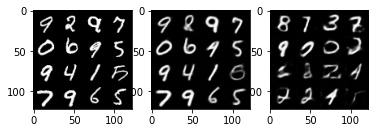

Iter: 02710/8000, Recon loss: 818.7842, KL div loss: 25.7265, Total loss: 844.5107
Iter: 02720/8000, Recon loss: 899.4044, KL div loss: 34.1475, Total loss: 933.5519
Iter: 02730/8000, Recon loss: 927.3372, KL div loss: 26.4744, Total loss: 953.8116
Iter: 02740/8000, Recon loss: 743.4061, KL div loss: 30.6896, Total loss: 774.0958
Iter: 02750/8000, Recon loss: 794.5715, KL div loss: 25.2559, Total loss: 819.8274


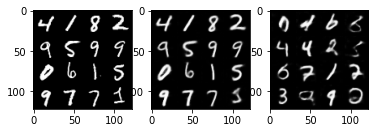

Iter: 02760/8000, Recon loss: 860.6763, KL div loss: 42.9051, Total loss: 903.5815
Iter: 02770/8000, Recon loss: 816.5540, KL div loss: 32.7285, Total loss: 849.2825
Iter: 02780/8000, Recon loss: 750.9890, KL div loss: 26.1150, Total loss: 777.1039
Iter: 02790/8000, Recon loss: 829.3262, KL div loss: 31.3883, Total loss: 860.7145
Iter: 02800/8000, Recon loss: 848.5297, KL div loss: 20.9538, Total loss: 869.4835


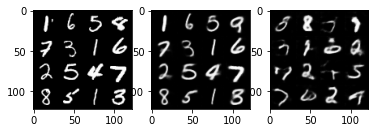

Iter: 02810/8000, Recon loss: 861.0769, KL div loss: 25.4621, Total loss: 886.5389
Iter: 02820/8000, Recon loss: 834.6764, KL div loss: 33.7135, Total loss: 868.3899
Iter: 02830/8000, Recon loss: 820.4036, KL div loss: 28.2573, Total loss: 848.6609
Iter: 02840/8000, Recon loss: 925.9229, KL div loss: 17.4722, Total loss: 943.3951
Iter: 02850/8000, Recon loss: 759.7957, KL div loss: 24.9428, Total loss: 784.7385


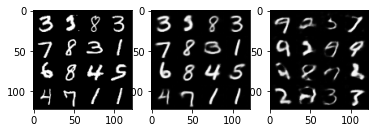

Iter: 02860/8000, Recon loss: 882.0815, KL div loss: 25.6305, Total loss: 907.7120
Iter: 02870/8000, Recon loss: 914.2983, KL div loss: 28.9800, Total loss: 943.2783
Iter: 02880/8000, Recon loss: 796.0748, KL div loss: 24.9451, Total loss: 821.0199
Iter: 02890/8000, Recon loss: 688.0660, KL div loss: 28.6970, Total loss: 716.7630
Iter: 02900/8000, Recon loss: 808.0975, KL div loss: 15.2024, Total loss: 823.3000


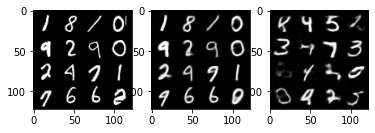

Iter: 02910/8000, Recon loss: 722.3301, KL div loss: 32.9030, Total loss: 755.2331
Iter: 02920/8000, Recon loss: 826.0269, KL div loss: 17.9017, Total loss: 843.9285
Iter: 02930/8000, Recon loss: 762.3839, KL div loss: 31.4198, Total loss: 793.8037
Iter: 02940/8000, Recon loss: 877.3420, KL div loss: 42.5257, Total loss: 919.8677
Iter: 02950/8000, Recon loss: 778.9857, KL div loss: 30.9344, Total loss: 809.9201


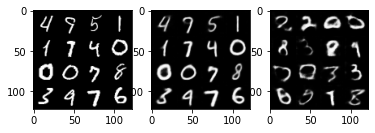

Iter: 02960/8000, Recon loss: 876.2866, KL div loss: 23.7668, Total loss: 900.0534
Iter: 02970/8000, Recon loss: 839.9865, KL div loss: 21.3697, Total loss: 861.3562
Iter: 02980/8000, Recon loss: 851.6896, KL div loss: 31.5479, Total loss: 883.2375
Iter: 02990/8000, Recon loss: 761.0070, KL div loss: 26.8665, Total loss: 787.8735
Iter: 03000/8000, Recon loss: 809.8723, KL div loss: 26.6417, Total loss: 836.5140


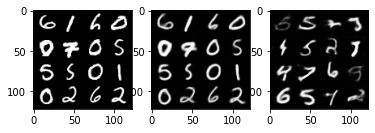

Iter: 03010/8000, Recon loss: 828.6653, KL div loss: 21.6758, Total loss: 850.3411
Iter: 03020/8000, Recon loss: 804.5020, KL div loss: 25.9573, Total loss: 830.4592
Iter: 03030/8000, Recon loss: 710.5650, KL div loss: 26.0256, Total loss: 736.5906
Iter: 03040/8000, Recon loss: 712.2586, KL div loss: 31.2267, Total loss: 743.4854
Iter: 03050/8000, Recon loss: 890.1569, KL div loss: 33.3722, Total loss: 923.5291


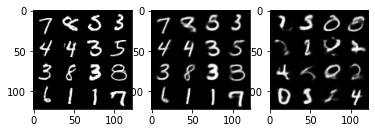

Iter: 03060/8000, Recon loss: 830.1788, KL div loss: 29.2517, Total loss: 859.4305
Iter: 03070/8000, Recon loss: 903.4987, KL div loss: 36.7818, Total loss: 940.2805
Iter: 03080/8000, Recon loss: 888.0930, KL div loss: 16.4047, Total loss: 904.4977
Iter: 03090/8000, Recon loss: 771.8163, KL div loss: 22.9727, Total loss: 794.7890
Iter: 03100/8000, Recon loss: 885.0530, KL div loss: 29.5019, Total loss: 914.5549


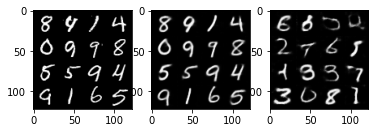

Iter: 03110/8000, Recon loss: 774.6443, KL div loss: 19.3944, Total loss: 794.0388
Iter: 03120/8000, Recon loss: 812.1941, KL div loss: 31.9764, Total loss: 844.1705
Iter: 03130/8000, Recon loss: 793.4644, KL div loss: 37.7417, Total loss: 831.2061
Iter: 03140/8000, Recon loss: 800.3644, KL div loss: 21.4413, Total loss: 821.8057
Iter: 03150/8000, Recon loss: 735.5448, KL div loss: 26.2242, Total loss: 761.7690


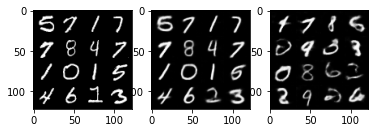

Iter: 03160/8000, Recon loss: 740.6144, KL div loss: 22.7479, Total loss: 763.3623
Iter: 03170/8000, Recon loss: 927.7986, KL div loss: 28.5041, Total loss: 956.3027
Iter: 03180/8000, Recon loss: 796.6180, KL div loss: 21.0957, Total loss: 817.7137
Iter: 03190/8000, Recon loss: 787.8102, KL div loss: 19.0405, Total loss: 806.8506
Iter: 03200/8000, Recon loss: 744.8066, KL div loss: 20.7540, Total loss: 765.5606


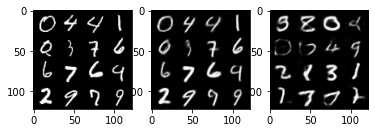

Iter: 03210/8000, Recon loss: 840.6719, KL div loss: 22.6842, Total loss: 863.3561
Iter: 03220/8000, Recon loss: 795.9062, KL div loss: 31.7177, Total loss: 827.6240
Iter: 03230/8000, Recon loss: 892.5331, KL div loss: 16.2054, Total loss: 908.7385
Iter: 03240/8000, Recon loss: 738.8699, KL div loss: 30.4556, Total loss: 769.3254
Iter: 03250/8000, Recon loss: 721.1647, KL div loss: 24.2770, Total loss: 745.4417


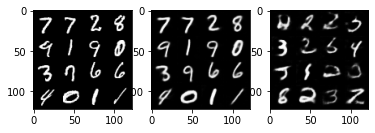

Iter: 03260/8000, Recon loss: 814.6897, KL div loss: 16.6044, Total loss: 831.2941
Iter: 03270/8000, Recon loss: 644.3660, KL div loss: 25.1111, Total loss: 669.4771
Iter: 03280/8000, Recon loss: 786.0676, KL div loss: 18.8291, Total loss: 804.8967
Iter: 03290/8000, Recon loss: 703.4854, KL div loss: 34.1932, Total loss: 737.6785
Iter: 03300/8000, Recon loss: 774.8806, KL div loss: 28.0995, Total loss: 802.9801


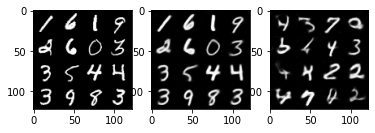

Iter: 03310/8000, Recon loss: 857.8517, KL div loss: 31.5333, Total loss: 889.3849
Iter: 03320/8000, Recon loss: 819.1127, KL div loss: 22.6691, Total loss: 841.7817
Iter: 03330/8000, Recon loss: 876.8842, KL div loss: 21.8227, Total loss: 898.7069
Iter: 03340/8000, Recon loss: 873.7167, KL div loss: 19.2454, Total loss: 892.9620
Iter: 03350/8000, Recon loss: 821.3776, KL div loss: 28.0126, Total loss: 849.3903


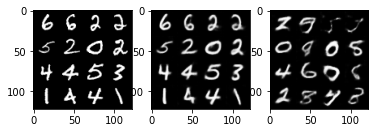

Iter: 03360/8000, Recon loss: 804.2007, KL div loss: 15.6531, Total loss: 819.8538
Iter: 03370/8000, Recon loss: 712.2220, KL div loss: 17.8716, Total loss: 730.0936
Iter: 03380/8000, Recon loss: 752.5620, KL div loss: 21.6465, Total loss: 774.2086
Iter: 03390/8000, Recon loss: 723.0328, KL div loss: 23.8041, Total loss: 746.8369
Iter: 03400/8000, Recon loss: 748.5319, KL div loss: 18.3760, Total loss: 766.9079


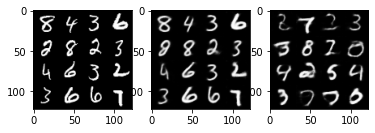

Iter: 03410/8000, Recon loss: 772.6199, KL div loss: 20.4357, Total loss: 793.0555
Iter: 03420/8000, Recon loss: 735.8683, KL div loss: 24.9144, Total loss: 760.7827
Iter: 03430/8000, Recon loss: 758.6270, KL div loss: 20.9433, Total loss: 779.5703
Iter: 03440/8000, Recon loss: 817.6713, KL div loss: 17.8291, Total loss: 835.5005
Iter: 03450/8000, Recon loss: 772.9885, KL div loss: 24.5077, Total loss: 797.4962


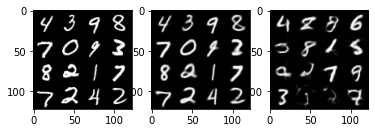

Iter: 03460/8000, Recon loss: 769.3917, KL div loss: 23.4004, Total loss: 792.7921
Iter: 03470/8000, Recon loss: 840.9404, KL div loss: 28.9267, Total loss: 869.8671
Iter: 03480/8000, Recon loss: 819.1127, KL div loss: 22.9901, Total loss: 842.1028
Iter: 03490/8000, Recon loss: 869.7404, KL div loss: 25.4983, Total loss: 895.2387
Iter: 03500/8000, Recon loss: 756.9227, KL div loss: 29.3065, Total loss: 786.2292


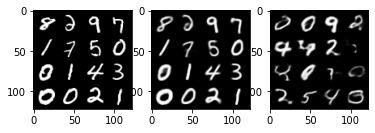

Iter: 03510/8000, Recon loss: 775.0350, KL div loss: 17.2738, Total loss: 792.3088
Iter: 03520/8000, Recon loss: 772.9432, KL div loss: 20.4719, Total loss: 793.4151
Iter: 03530/8000, Recon loss: 707.4025, KL div loss: 26.2116, Total loss: 733.6141
Iter: 03540/8000, Recon loss: 644.6558, KL div loss: 25.0126, Total loss: 669.6684
Iter: 03550/8000, Recon loss: 840.6263, KL div loss: 21.7729, Total loss: 862.3992


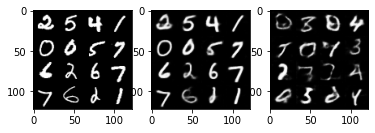

Iter: 03560/8000, Recon loss: 788.6575, KL div loss: 26.1817, Total loss: 814.8392
Iter: 03570/8000, Recon loss: 776.4225, KL div loss: 19.9000, Total loss: 796.3225
Iter: 03580/8000, Recon loss: 787.4851, KL div loss: 23.6810, Total loss: 811.1661
Iter: 03590/8000, Recon loss: 769.7737, KL div loss: 19.8761, Total loss: 789.6499
Iter: 03600/8000, Recon loss: 843.9438, KL div loss: 29.7806, Total loss: 873.7245


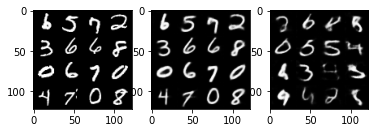

Iter: 03610/8000, Recon loss: 865.0255, KL div loss: 22.6711, Total loss: 887.6967
Iter: 03620/8000, Recon loss: 837.6946, KL div loss: 24.8348, Total loss: 862.5294
Iter: 03630/8000, Recon loss: 828.7214, KL div loss: 18.8817, Total loss: 847.6031
Iter: 03640/8000, Recon loss: 746.2197, KL div loss: 14.1014, Total loss: 760.3211
Iter: 03650/8000, Recon loss: 697.7386, KL div loss: 14.9771, Total loss: 712.7158


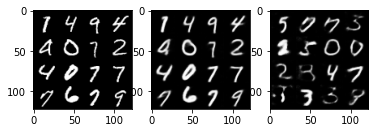

Iter: 03660/8000, Recon loss: 732.7179, KL div loss: 24.8374, Total loss: 757.5553
Iter: 03670/8000, Recon loss: 756.2277, KL div loss: 35.9164, Total loss: 792.1441
Iter: 03680/8000, Recon loss: 955.8270, KL div loss: 18.9560, Total loss: 974.7830
Iter: 03690/8000, Recon loss: 792.5491, KL div loss: 25.6598, Total loss: 818.2089
Iter: 03700/8000, Recon loss: 881.5028, KL div loss: 8.8163, Total loss: 890.3191


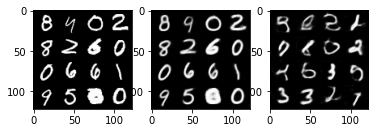

Iter: 03710/8000, Recon loss: 810.2241, KL div loss: 17.9875, Total loss: 828.2115
Iter: 03720/8000, Recon loss: 756.9113, KL div loss: 18.4772, Total loss: 775.3885
Iter: 03730/8000, Recon loss: 766.7565, KL div loss: 22.4732, Total loss: 789.2297
Iter: 03740/8000, Recon loss: 733.4287, KL div loss: 24.3782, Total loss: 757.8069
Iter: 03750/8000, Recon loss: 897.3060, KL div loss: 19.5714, Total loss: 916.8774


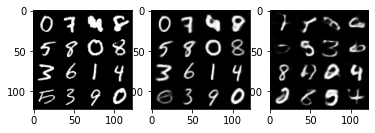

Iter: 03760/8000, Recon loss: 814.8489, KL div loss: 20.4495, Total loss: 835.2983
Iter: 03770/8000, Recon loss: 804.9047, KL div loss: 27.7877, Total loss: 832.6923
Iter: 03780/8000, Recon loss: 731.4592, KL div loss: 14.7559, Total loss: 746.2151
Iter: 03790/8000, Recon loss: 864.1290, KL div loss: 18.0048, Total loss: 882.1339
Iter: 03800/8000, Recon loss: 751.0668, KL div loss: 16.5650, Total loss: 767.6318


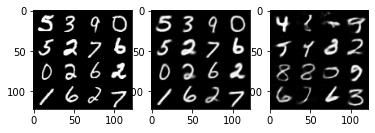

Iter: 03810/8000, Recon loss: 822.1662, KL div loss: 19.6083, Total loss: 841.7745
Iter: 03820/8000, Recon loss: 705.2151, KL div loss: 18.5686, Total loss: 723.7837
Iter: 03830/8000, Recon loss: 736.1128, KL div loss: 30.8635, Total loss: 766.9763
Iter: 03840/8000, Recon loss: 727.3387, KL div loss: 17.1995, Total loss: 744.5382
Iter: 03850/8000, Recon loss: 723.6551, KL div loss: 26.0897, Total loss: 749.7448


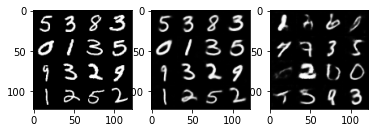

Iter: 03860/8000, Recon loss: 847.9138, KL div loss: 23.5894, Total loss: 871.5032
Iter: 03870/8000, Recon loss: 780.1793, KL div loss: 15.9142, Total loss: 796.0935
Iter: 03880/8000, Recon loss: 660.8250, KL div loss: 26.3797, Total loss: 687.2047
Iter: 03890/8000, Recon loss: 773.4215, KL div loss: 21.4047, Total loss: 794.8262
Iter: 03900/8000, Recon loss: 759.0554, KL div loss: 19.3422, Total loss: 778.3976


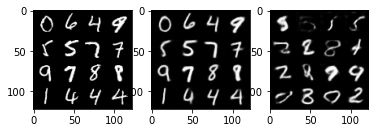

Iter: 03910/8000, Recon loss: 780.5486, KL div loss: 22.4459, Total loss: 802.9945
Iter: 03920/8000, Recon loss: 704.1995, KL div loss: 26.0893, Total loss: 730.2888
Iter: 03930/8000, Recon loss: 737.0670, KL div loss: 30.9216, Total loss: 767.9886
Iter: 03940/8000, Recon loss: 729.9368, KL div loss: 20.5034, Total loss: 750.4402
Iter: 03950/8000, Recon loss: 786.0364, KL div loss: 23.1578, Total loss: 809.1942


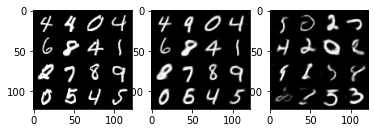

Iter: 03960/8000, Recon loss: 794.7439, KL div loss: 15.9541, Total loss: 810.6980
Iter: 03970/8000, Recon loss: 810.1676, KL div loss: 25.9151, Total loss: 836.0827
Iter: 03980/8000, Recon loss: 731.2521, KL div loss: 23.6626, Total loss: 754.9147
Iter: 03990/8000, Recon loss: 798.9713, KL div loss: 19.6402, Total loss: 818.6115
Iter: 04000/8000, Recon loss: 742.1333, KL div loss: 15.3616, Total loss: 757.4949


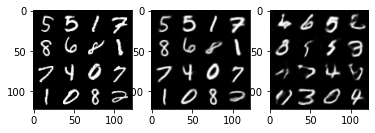

Iter: 04010/8000, Recon loss: 808.0605, KL div loss: 17.7895, Total loss: 825.8501
Iter: 04020/8000, Recon loss: 737.2875, KL div loss: 21.4614, Total loss: 758.7489
Iter: 04030/8000, Recon loss: 837.0317, KL div loss: 24.6231, Total loss: 861.6547
Iter: 04040/8000, Recon loss: 770.9954, KL div loss: 20.1363, Total loss: 791.1317
Iter: 04050/8000, Recon loss: 871.7004, KL div loss: 22.0878, Total loss: 893.7882


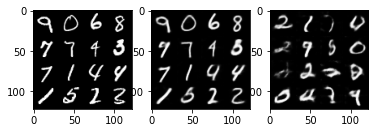

Iter: 04060/8000, Recon loss: 710.0568, KL div loss: 16.8550, Total loss: 726.9118
Iter: 04070/8000, Recon loss: 722.3335, KL div loss: 12.9774, Total loss: 735.3109
Iter: 04080/8000, Recon loss: 780.5941, KL div loss: 17.2872, Total loss: 797.8813
Iter: 04090/8000, Recon loss: 717.3577, KL div loss: 17.8997, Total loss: 735.2574
Iter: 04100/8000, Recon loss: 688.3190, KL div loss: 28.0294, Total loss: 716.3483


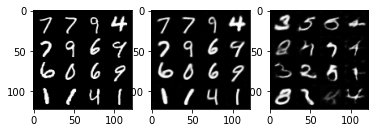

Iter: 04110/8000, Recon loss: 720.4722, KL div loss: 24.2448, Total loss: 744.7170
Iter: 04120/8000, Recon loss: 677.2551, KL div loss: 24.3764, Total loss: 701.6315
Iter: 04130/8000, Recon loss: 750.4982, KL div loss: 16.6701, Total loss: 767.1683
Iter: 04140/8000, Recon loss: 775.8711, KL div loss: 30.3022, Total loss: 806.1733
Iter: 04150/8000, Recon loss: 766.8197, KL div loss: 18.1473, Total loss: 784.9670


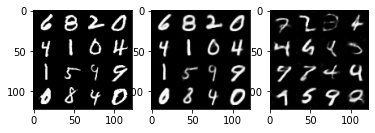

Iter: 04160/8000, Recon loss: 654.9675, KL div loss: 21.9917, Total loss: 676.9592
Iter: 04170/8000, Recon loss: 819.5078, KL div loss: 17.8804, Total loss: 837.3882
Iter: 04180/8000, Recon loss: 766.5023, KL div loss: 14.4005, Total loss: 780.9028
Iter: 04190/8000, Recon loss: 771.4664, KL div loss: 26.8186, Total loss: 798.2849
Iter: 04200/8000, Recon loss: 815.6664, KL div loss: 15.2902, Total loss: 830.9565


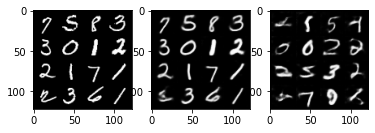

Iter: 04210/8000, Recon loss: 760.8932, KL div loss: 22.6080, Total loss: 783.5012
Iter: 04220/8000, Recon loss: 700.0386, KL div loss: 24.5579, Total loss: 724.5965
Iter: 04230/8000, Recon loss: 691.0099, KL div loss: 23.2958, Total loss: 714.3058
Iter: 04240/8000, Recon loss: 877.1240, KL div loss: 21.7058, Total loss: 898.8298
Iter: 04250/8000, Recon loss: 659.8734, KL div loss: 32.8614, Total loss: 692.7348


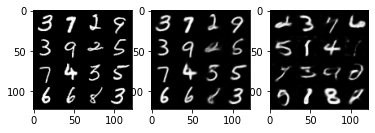

Iter: 04260/8000, Recon loss: 722.1879, KL div loss: 18.0669, Total loss: 740.2548
Iter: 04270/8000, Recon loss: 779.5131, KL div loss: 14.9613, Total loss: 794.4744
Iter: 04280/8000, Recon loss: 709.8585, KL div loss: 23.6174, Total loss: 733.4758
Iter: 04290/8000, Recon loss: 797.3986, KL div loss: 17.8756, Total loss: 815.2743
Iter: 04300/8000, Recon loss: 849.3236, KL div loss: 19.7343, Total loss: 869.0579


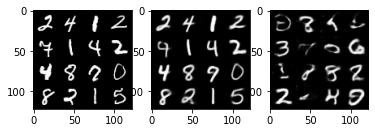

Iter: 04310/8000, Recon loss: 739.9606, KL div loss: 18.4551, Total loss: 758.4156
Iter: 04320/8000, Recon loss: 800.9818, KL div loss: 16.5950, Total loss: 817.5768
Iter: 04330/8000, Recon loss: 688.0605, KL div loss: 25.5125, Total loss: 713.5731
Iter: 04340/8000, Recon loss: 753.2649, KL div loss: 14.2052, Total loss: 767.4702
Iter: 04350/8000, Recon loss: 788.4856, KL div loss: 20.4869, Total loss: 808.9725


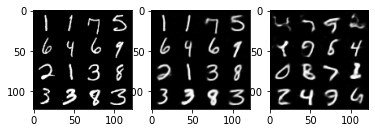

Iter: 04360/8000, Recon loss: 751.7665, KL div loss: 15.4042, Total loss: 767.1707
Iter: 04370/8000, Recon loss: 897.3458, KL div loss: 21.5264, Total loss: 918.8722
Iter: 04380/8000, Recon loss: 715.1340, KL div loss: 19.1441, Total loss: 734.2781
Iter: 04390/8000, Recon loss: 716.6609, KL div loss: 26.4578, Total loss: 743.1187
Iter: 04400/8000, Recon loss: 802.7261, KL div loss: 13.8492, Total loss: 816.5753


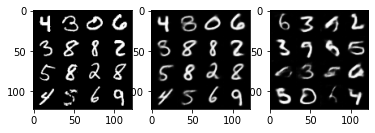

Iter: 04410/8000, Recon loss: 680.2000, KL div loss: 20.5629, Total loss: 700.7628
Iter: 04420/8000, Recon loss: 682.0043, KL div loss: 16.4395, Total loss: 698.4438
Iter: 04430/8000, Recon loss: 829.9552, KL div loss: 12.3075, Total loss: 842.2626
Iter: 04440/8000, Recon loss: 680.0051, KL div loss: 13.2517, Total loss: 693.2568
Iter: 04450/8000, Recon loss: 762.6919, KL div loss: 21.3107, Total loss: 784.0026


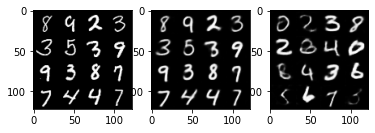

Iter: 04460/8000, Recon loss: 868.5528, KL div loss: 14.5363, Total loss: 883.0891
Iter: 04470/8000, Recon loss: 789.4592, KL div loss: 15.6849, Total loss: 805.1442
Iter: 04480/8000, Recon loss: 614.1370, KL div loss: 20.0066, Total loss: 634.1436
Iter: 04490/8000, Recon loss: 817.4593, KL div loss: 26.4717, Total loss: 843.9310
Iter: 04500/8000, Recon loss: 606.8327, KL div loss: 16.1654, Total loss: 622.9980


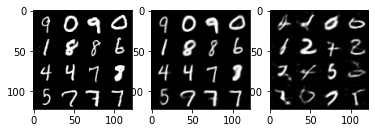

Iter: 04510/8000, Recon loss: 934.4128, KL div loss: 23.4690, Total loss: 957.8818
Iter: 04520/8000, Recon loss: 756.4738, KL div loss: 23.9676, Total loss: 780.4414
Iter: 04530/8000, Recon loss: 799.7990, KL div loss: 14.9045, Total loss: 814.7034
Iter: 04540/8000, Recon loss: 718.5192, KL div loss: 18.3531, Total loss: 736.8723
Iter: 04550/8000, Recon loss: 723.8348, KL div loss: 17.7079, Total loss: 741.5428


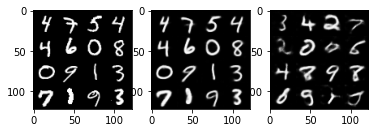

Iter: 04560/8000, Recon loss: 705.9818, KL div loss: 12.5769, Total loss: 718.5587
Iter: 04570/8000, Recon loss: 819.0486, KL div loss: 20.3140, Total loss: 839.3626
Iter: 04580/8000, Recon loss: 815.1639, KL div loss: 19.6713, Total loss: 834.8352
Iter: 04590/8000, Recon loss: 765.0676, KL div loss: 21.2306, Total loss: 786.2983
Iter: 04600/8000, Recon loss: 693.9592, KL div loss: 16.2494, Total loss: 710.2086


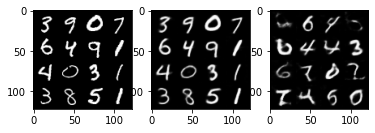

Iter: 04610/8000, Recon loss: 705.4027, KL div loss: 19.8609, Total loss: 725.2637
Iter: 04620/8000, Recon loss: 739.2970, KL div loss: 25.1342, Total loss: 764.4312
Iter: 04630/8000, Recon loss: 716.1713, KL div loss: 27.2920, Total loss: 743.4633
Iter: 04640/8000, Recon loss: 787.0396, KL div loss: 20.6510, Total loss: 807.6906
Iter: 04650/8000, Recon loss: 828.2147, KL div loss: 20.0903, Total loss: 848.3051


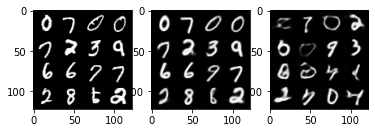

Iter: 04660/8000, Recon loss: 807.4197, KL div loss: 19.3406, Total loss: 826.7603
Iter: 04670/8000, Recon loss: 641.5027, KL div loss: 26.1531, Total loss: 667.6558
Iter: 04680/8000, Recon loss: 714.3916, KL div loss: 18.6077, Total loss: 732.9993
Iter: 04690/8000, Recon loss: 717.1353, KL div loss: 19.8414, Total loss: 736.9766
Iter: 04700/8000, Recon loss: 782.5068, KL div loss: 9.8039, Total loss: 792.3108


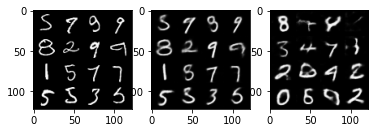

Iter: 04710/8000, Recon loss: 751.5955, KL div loss: 21.8249, Total loss: 773.4204
Iter: 04720/8000, Recon loss: 757.2764, KL div loss: 18.6296, Total loss: 775.9059
Iter: 04730/8000, Recon loss: 770.5592, KL div loss: 16.5741, Total loss: 787.1333
Iter: 04740/8000, Recon loss: 725.6072, KL div loss: 11.8165, Total loss: 737.4236
Iter: 04750/8000, Recon loss: 742.9187, KL div loss: 13.6559, Total loss: 756.5746


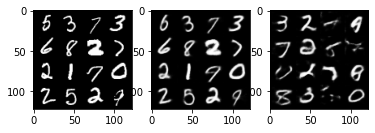

Iter: 04760/8000, Recon loss: 727.0870, KL div loss: 16.2358, Total loss: 743.3228
Iter: 04770/8000, Recon loss: 801.8293, KL div loss: 23.6772, Total loss: 825.5065
Iter: 04780/8000, Recon loss: 781.2534, KL div loss: 22.1763, Total loss: 803.4297
Iter: 04790/8000, Recon loss: 662.1119, KL div loss: 21.3316, Total loss: 683.4435
Iter: 04800/8000, Recon loss: 725.3618, KL div loss: 22.0717, Total loss: 747.4335


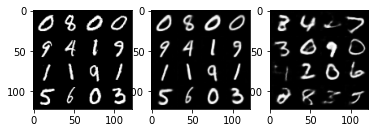

Iter: 04810/8000, Recon loss: 788.2944, KL div loss: 16.9426, Total loss: 805.2371
Iter: 04820/8000, Recon loss: 725.5297, KL div loss: 23.5233, Total loss: 749.0530
Iter: 04830/8000, Recon loss: 691.5270, KL div loss: 19.5831, Total loss: 711.1101
Iter: 04840/8000, Recon loss: 785.2593, KL div loss: 19.3143, Total loss: 804.5735
Iter: 04850/8000, Recon loss: 715.9872, KL div loss: 14.7586, Total loss: 730.7458


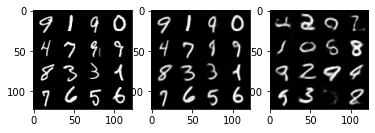

Iter: 04860/8000, Recon loss: 730.9803, KL div loss: 25.1566, Total loss: 756.1370
Iter: 04870/8000, Recon loss: 559.0146, KL div loss: 15.6549, Total loss: 574.6696
Iter: 04880/8000, Recon loss: 754.6627, KL div loss: 18.9847, Total loss: 773.6474
Iter: 04890/8000, Recon loss: 778.6216, KL div loss: 10.7504, Total loss: 789.3721
Iter: 04900/8000, Recon loss: 759.4359, KL div loss: 17.2533, Total loss: 776.6892


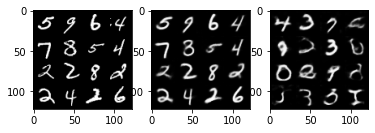

Iter: 04910/8000, Recon loss: 844.8476, KL div loss: 19.7791, Total loss: 864.6267
Iter: 04920/8000, Recon loss: 726.0226, KL div loss: 17.1444, Total loss: 743.1670
Iter: 04930/8000, Recon loss: 768.3098, KL div loss: 20.0457, Total loss: 788.3555
Iter: 04940/8000, Recon loss: 781.3200, KL div loss: 21.3132, Total loss: 802.6332
Iter: 04950/8000, Recon loss: 771.1780, KL div loss: 12.2854, Total loss: 783.4634


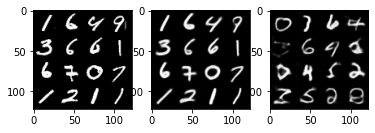

Iter: 04960/8000, Recon loss: 763.6338, KL div loss: 18.5907, Total loss: 782.2245
Iter: 04970/8000, Recon loss: 746.5777, KL div loss: 18.5022, Total loss: 765.0798
Iter: 04980/8000, Recon loss: 804.1544, KL div loss: 22.4558, Total loss: 826.6102
Iter: 04990/8000, Recon loss: 785.4371, KL div loss: 17.1782, Total loss: 802.6154
Iter: 05000/8000, Recon loss: 706.2880, KL div loss: 22.7289, Total loss: 729.0170


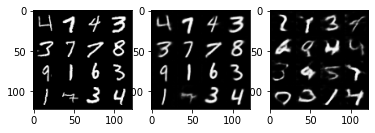

Iter: 05010/8000, Recon loss: 626.2311, KL div loss: 15.4695, Total loss: 641.7006
Iter: 05020/8000, Recon loss: 758.8861, KL div loss: 20.7600, Total loss: 779.6461
Iter: 05030/8000, Recon loss: 660.1367, KL div loss: 21.9664, Total loss: 682.1031
Iter: 05040/8000, Recon loss: 710.7423, KL div loss: 20.0666, Total loss: 730.8090
Iter: 05050/8000, Recon loss: 774.0133, KL div loss: 13.8827, Total loss: 787.8960


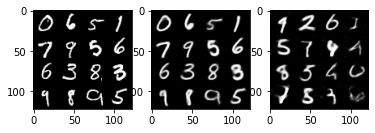

Iter: 05060/8000, Recon loss: 678.4368, KL div loss: 19.7068, Total loss: 698.1436
Iter: 05070/8000, Recon loss: 805.3633, KL div loss: 24.1122, Total loss: 829.4755
Iter: 05080/8000, Recon loss: 761.0710, KL div loss: 20.0371, Total loss: 781.1082
Iter: 05090/8000, Recon loss: 752.9636, KL div loss: 12.1392, Total loss: 765.1028
Iter: 05100/8000, Recon loss: 833.6091, KL div loss: 20.1915, Total loss: 853.8005


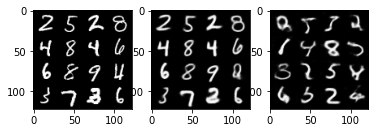

Iter: 05110/8000, Recon loss: 744.0503, KL div loss: 15.2162, Total loss: 759.2665
Iter: 05120/8000, Recon loss: 754.6595, KL div loss: 16.4645, Total loss: 771.1240
Iter: 05130/8000, Recon loss: 716.5348, KL div loss: 18.8985, Total loss: 735.4332
Iter: 05140/8000, Recon loss: 727.0452, KL div loss: 23.1864, Total loss: 750.2316
Iter: 05150/8000, Recon loss: 777.6080, KL div loss: 11.5169, Total loss: 789.1249


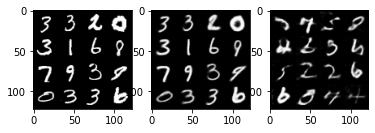

Iter: 05160/8000, Recon loss: 784.0096, KL div loss: 21.4097, Total loss: 805.4193
Iter: 05170/8000, Recon loss: 767.7498, KL div loss: 32.1881, Total loss: 799.9378
Iter: 05180/8000, Recon loss: 741.3284, KL div loss: 25.9389, Total loss: 767.2673
Iter: 05190/8000, Recon loss: 730.5914, KL div loss: 20.4201, Total loss: 751.0115
Iter: 05200/8000, Recon loss: 798.5133, KL div loss: 23.2068, Total loss: 821.7202


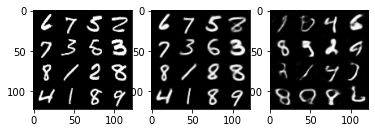

Iter: 05210/8000, Recon loss: 697.7195, KL div loss: 22.1866, Total loss: 719.9061
Iter: 05220/8000, Recon loss: 758.4171, KL div loss: 18.0847, Total loss: 776.5018
Iter: 05230/8000, Recon loss: 702.7020, KL div loss: 13.7106, Total loss: 716.4127
Iter: 05240/8000, Recon loss: 740.4667, KL div loss: 26.0888, Total loss: 766.5555
Iter: 05250/8000, Recon loss: 744.7849, KL div loss: 23.8139, Total loss: 768.5988


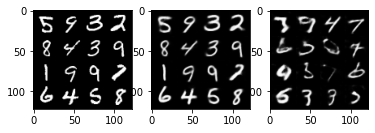

Iter: 05260/8000, Recon loss: 792.8601, KL div loss: 19.5821, Total loss: 812.4421
Iter: 05270/8000, Recon loss: 619.1666, KL div loss: 23.1852, Total loss: 642.3518
Iter: 05280/8000, Recon loss: 683.9832, KL div loss: 19.8720, Total loss: 703.8553
Iter: 05290/8000, Recon loss: 799.6954, KL div loss: 24.0463, Total loss: 823.7417
Iter: 05300/8000, Recon loss: 669.1886, KL div loss: 17.4431, Total loss: 686.6317


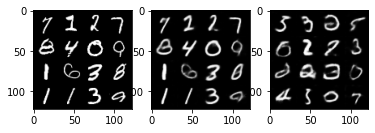

Iter: 05310/8000, Recon loss: 655.6283, KL div loss: 20.9615, Total loss: 676.5898
Iter: 05320/8000, Recon loss: 688.9764, KL div loss: 22.9975, Total loss: 711.9739
Iter: 05330/8000, Recon loss: 649.8813, KL div loss: 19.3926, Total loss: 669.2739
Iter: 05340/8000, Recon loss: 628.3829, KL div loss: 15.5399, Total loss: 643.9229
Iter: 05350/8000, Recon loss: 562.7850, KL div loss: 14.5568, Total loss: 577.3418


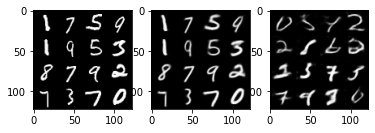

Iter: 05360/8000, Recon loss: 729.2256, KL div loss: 20.6807, Total loss: 749.9064
Iter: 05370/8000, Recon loss: 738.3833, KL div loss: 15.1415, Total loss: 753.5248
Iter: 05380/8000, Recon loss: 701.4731, KL div loss: 15.7838, Total loss: 717.2568
Iter: 05390/8000, Recon loss: 780.5470, KL div loss: 24.5905, Total loss: 805.1375
Iter: 05400/8000, Recon loss: 624.9127, KL div loss: 22.7096, Total loss: 647.6223


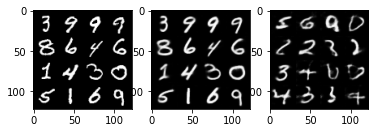

Iter: 05410/8000, Recon loss: 640.8862, KL div loss: 14.6207, Total loss: 655.5069
Iter: 05420/8000, Recon loss: 840.1512, KL div loss: 23.0669, Total loss: 863.2181
Iter: 05430/8000, Recon loss: 777.9191, KL div loss: 23.6221, Total loss: 801.5413
Iter: 05440/8000, Recon loss: 703.8463, KL div loss: 16.2042, Total loss: 720.0505
Iter: 05450/8000, Recon loss: 779.2496, KL div loss: 15.8114, Total loss: 795.0610


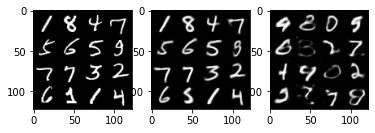

Iter: 05460/8000, Recon loss: 732.5899, KL div loss: 16.1081, Total loss: 748.6980
Iter: 05470/8000, Recon loss: 724.1779, KL div loss: 16.7255, Total loss: 740.9034
Iter: 05480/8000, Recon loss: 800.8613, KL div loss: 21.8039, Total loss: 822.6652
Iter: 05490/8000, Recon loss: 756.6736, KL div loss: 18.9183, Total loss: 775.5919
Iter: 05500/8000, Recon loss: 739.7917, KL div loss: 20.0463, Total loss: 759.8381


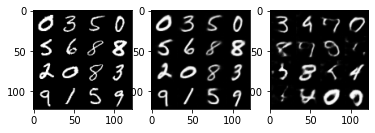

Iter: 05510/8000, Recon loss: 646.2568, KL div loss: 16.7332, Total loss: 662.9901
Iter: 05520/8000, Recon loss: 790.8004, KL div loss: 22.4909, Total loss: 813.2913
Iter: 05530/8000, Recon loss: 743.9313, KL div loss: 23.3360, Total loss: 767.2673
Iter: 05540/8000, Recon loss: 731.7922, KL div loss: 20.3191, Total loss: 752.1113
Iter: 05550/8000, Recon loss: 771.6597, KL div loss: 11.4105, Total loss: 783.0702


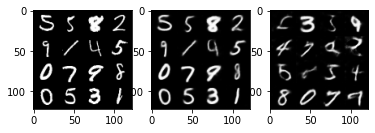

Iter: 05560/8000, Recon loss: 660.7513, KL div loss: 15.7426, Total loss: 676.4939
Iter: 05570/8000, Recon loss: 664.4088, KL div loss: 20.3582, Total loss: 684.7670
Iter: 05580/8000, Recon loss: 713.8169, KL div loss: 15.8630, Total loss: 729.6799
Iter: 05590/8000, Recon loss: 677.3702, KL div loss: 20.1716, Total loss: 697.5419
Iter: 05600/8000, Recon loss: 739.3796, KL div loss: 18.0276, Total loss: 757.4072


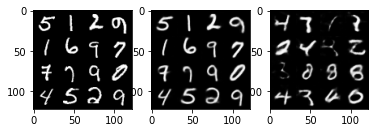

Iter: 05610/8000, Recon loss: 687.6881, KL div loss: 16.3239, Total loss: 704.0120
Iter: 05620/8000, Recon loss: 775.9760, KL div loss: 26.3554, Total loss: 802.3314
Iter: 05630/8000, Recon loss: 708.6075, KL div loss: 16.5715, Total loss: 725.1790
Iter: 05640/8000, Recon loss: 674.5093, KL div loss: 14.6462, Total loss: 689.1555
Iter: 05650/8000, Recon loss: 725.5654, KL div loss: 18.0706, Total loss: 743.6360


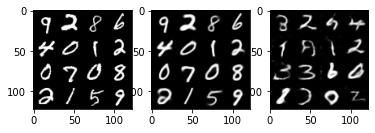

Iter: 05660/8000, Recon loss: 813.2841, KL div loss: 15.9990, Total loss: 829.2830
Iter: 05670/8000, Recon loss: 712.9839, KL div loss: 22.2628, Total loss: 735.2468
Iter: 05680/8000, Recon loss: 670.2698, KL div loss: 19.5407, Total loss: 689.8105
Iter: 05690/8000, Recon loss: 720.1714, KL div loss: 15.8621, Total loss: 736.0335
Iter: 05700/8000, Recon loss: 692.0602, KL div loss: 18.5718, Total loss: 710.6321


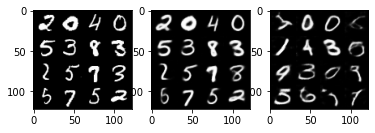

Iter: 05710/8000, Recon loss: 646.7336, KL div loss: 14.3849, Total loss: 661.1185
Iter: 05720/8000, Recon loss: 745.6909, KL div loss: 11.4860, Total loss: 757.1769
Iter: 05730/8000, Recon loss: 775.5597, KL div loss: 23.7862, Total loss: 799.3459
Iter: 05740/8000, Recon loss: 721.0344, KL div loss: 21.5264, Total loss: 742.5608
Iter: 05750/8000, Recon loss: 683.3610, KL div loss: 13.6505, Total loss: 697.0115


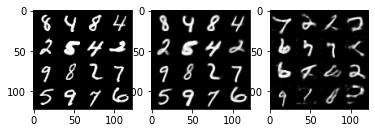

Iter: 05760/8000, Recon loss: 635.2562, KL div loss: 18.4626, Total loss: 653.7188
Iter: 05770/8000, Recon loss: 723.9576, KL div loss: 14.8683, Total loss: 738.8259
Iter: 05780/8000, Recon loss: 679.2784, KL div loss: 20.8205, Total loss: 700.0989
Iter: 05790/8000, Recon loss: 713.5375, KL div loss: 16.0748, Total loss: 729.6122
Iter: 05800/8000, Recon loss: 626.7029, KL div loss: 17.8685, Total loss: 644.5714


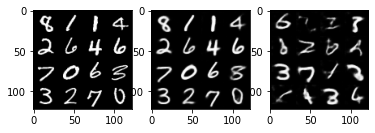

Iter: 05810/8000, Recon loss: 794.5795, KL div loss: 24.2316, Total loss: 818.8112
Iter: 05820/8000, Recon loss: 797.3231, KL div loss: 22.0925, Total loss: 819.4156
Iter: 05830/8000, Recon loss: 696.5719, KL div loss: 17.3581, Total loss: 713.9300
Iter: 05840/8000, Recon loss: 700.5796, KL div loss: 18.3823, Total loss: 718.9619
Iter: 05850/8000, Recon loss: 666.4357, KL div loss: 20.5737, Total loss: 687.0093


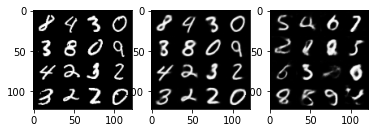

Iter: 05860/8000, Recon loss: 862.0731, KL div loss: 14.8894, Total loss: 876.9626
Iter: 05870/8000, Recon loss: 704.0915, KL div loss: 15.4026, Total loss: 719.4941
Iter: 05880/8000, Recon loss: 635.1567, KL div loss: 15.1392, Total loss: 650.2960
Iter: 05890/8000, Recon loss: 822.8184, KL div loss: 16.6173, Total loss: 839.4357
Iter: 05900/8000, Recon loss: 602.5471, KL div loss: 17.6235, Total loss: 620.1707


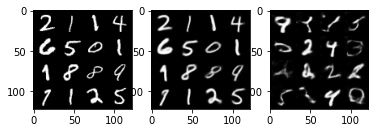

Iter: 05910/8000, Recon loss: 781.6039, KL div loss: 20.0141, Total loss: 801.6180
Iter: 05920/8000, Recon loss: 673.6990, KL div loss: 18.0041, Total loss: 691.7031
Iter: 05930/8000, Recon loss: 799.4884, KL div loss: 17.4548, Total loss: 816.9432
Iter: 05940/8000, Recon loss: 606.5179, KL div loss: 20.3307, Total loss: 626.8486
Iter: 05950/8000, Recon loss: 693.9629, KL div loss: 19.3189, Total loss: 713.2819


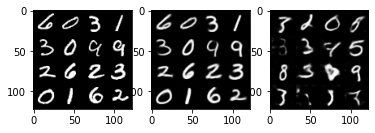

Iter: 05960/8000, Recon loss: 774.4290, KL div loss: 16.6629, Total loss: 791.0919
Iter: 05970/8000, Recon loss: 681.8344, KL div loss: 19.0212, Total loss: 700.8556
Iter: 05980/8000, Recon loss: 776.1555, KL div loss: 14.1335, Total loss: 790.2891
Iter: 05990/8000, Recon loss: 717.4684, KL div loss: 16.0985, Total loss: 733.5669
Iter: 06000/8000, Recon loss: 679.0126, KL div loss: 17.1929, Total loss: 696.2056


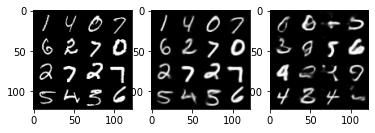

Iter: 06010/8000, Recon loss: 658.9017, KL div loss: 15.3040, Total loss: 674.2057
Iter: 06020/8000, Recon loss: 632.8483, KL div loss: 16.6264, Total loss: 649.4747
Iter: 06030/8000, Recon loss: 720.7601, KL div loss: 16.6494, Total loss: 737.4095
Iter: 06040/8000, Recon loss: 753.1464, KL div loss: 18.3510, Total loss: 771.4974
Iter: 06050/8000, Recon loss: 699.3124, KL div loss: 18.5391, Total loss: 717.8514


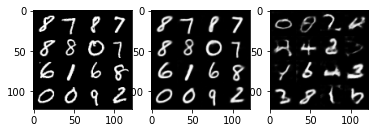

Iter: 06060/8000, Recon loss: 695.5228, KL div loss: 22.6575, Total loss: 718.1804
Iter: 06070/8000, Recon loss: 707.5327, KL div loss: 17.9807, Total loss: 725.5134
Iter: 06080/8000, Recon loss: 693.3761, KL div loss: 19.8795, Total loss: 713.2556
Iter: 06090/8000, Recon loss: 692.1758, KL div loss: 17.9438, Total loss: 710.1196
Iter: 06100/8000, Recon loss: 685.4602, KL div loss: 13.7511, Total loss: 699.2114


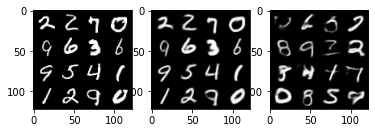

Iter: 06110/8000, Recon loss: 813.8612, KL div loss: 22.4107, Total loss: 836.2719
Iter: 06120/8000, Recon loss: 692.8887, KL div loss: 13.8229, Total loss: 706.7115
Iter: 06130/8000, Recon loss: 643.2569, KL div loss: 12.9899, Total loss: 656.2468
Iter: 06140/8000, Recon loss: 768.7304, KL div loss: 17.9774, Total loss: 786.7078
Iter: 06150/8000, Recon loss: 669.7811, KL div loss: 19.7246, Total loss: 689.5057


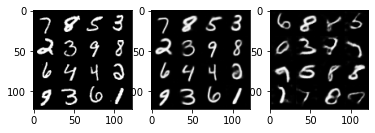

Iter: 06160/8000, Recon loss: 683.8672, KL div loss: 20.5810, Total loss: 704.4482
Iter: 06170/8000, Recon loss: 751.6693, KL div loss: 13.4768, Total loss: 765.1461
Iter: 06180/8000, Recon loss: 798.1913, KL div loss: 21.3881, Total loss: 819.5794
Iter: 06190/8000, Recon loss: 624.9943, KL div loss: 15.6400, Total loss: 640.6343
Iter: 06200/8000, Recon loss: 646.0315, KL div loss: 18.2032, Total loss: 664.2347


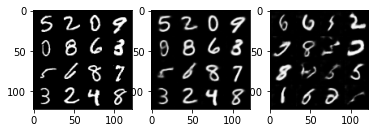

Iter: 06210/8000, Recon loss: 716.7339, KL div loss: 9.4063, Total loss: 726.1401
Iter: 06220/8000, Recon loss: 728.2393, KL div loss: 15.2716, Total loss: 743.5109
Iter: 06230/8000, Recon loss: 737.6177, KL div loss: 21.0302, Total loss: 758.6478
Iter: 06240/8000, Recon loss: 659.7615, KL div loss: 19.2206, Total loss: 678.9821
Iter: 06250/8000, Recon loss: 783.8796, KL div loss: 18.1676, Total loss: 802.0472


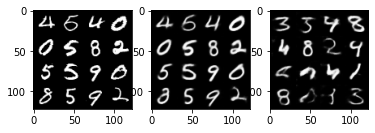

Iter: 06260/8000, Recon loss: 650.5999, KL div loss: 12.4414, Total loss: 663.0413
Iter: 06270/8000, Recon loss: 742.6168, KL div loss: 17.0068, Total loss: 759.6236
Iter: 06280/8000, Recon loss: 626.4592, KL div loss: 14.0494, Total loss: 640.5085
Iter: 06290/8000, Recon loss: 608.3021, KL div loss: 16.2751, Total loss: 624.5772
Iter: 06300/8000, Recon loss: 780.9302, KL div loss: 15.6987, Total loss: 796.6288


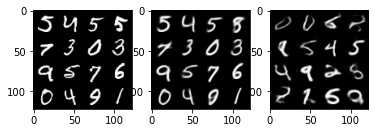

Iter: 06310/8000, Recon loss: 687.4768, KL div loss: 16.9120, Total loss: 704.3888
Iter: 06320/8000, Recon loss: 646.2677, KL div loss: 25.3166, Total loss: 671.5843
Iter: 06330/8000, Recon loss: 735.6117, KL div loss: 15.2918, Total loss: 750.9036
Iter: 06340/8000, Recon loss: 745.7901, KL div loss: 13.1377, Total loss: 758.9278
Iter: 06350/8000, Recon loss: 635.4830, KL div loss: 22.7101, Total loss: 658.1932


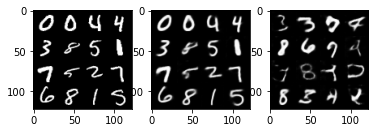

Iter: 06360/8000, Recon loss: 646.5736, KL div loss: 18.8821, Total loss: 665.4557
Iter: 06370/8000, Recon loss: 685.3505, KL div loss: 15.2193, Total loss: 700.5698
Iter: 06380/8000, Recon loss: 684.5881, KL div loss: 24.7082, Total loss: 709.2963
Iter: 06390/8000, Recon loss: 670.1409, KL div loss: 18.8130, Total loss: 688.9539
Iter: 06400/8000, Recon loss: 648.4556, KL div loss: 19.7061, Total loss: 668.1616


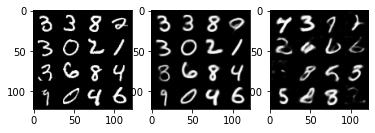

Iter: 06410/8000, Recon loss: 802.6991, KL div loss: 13.6380, Total loss: 816.3370
Iter: 06420/8000, Recon loss: 743.2042, KL div loss: 15.6542, Total loss: 758.8584
Iter: 06430/8000, Recon loss: 723.2623, KL div loss: 17.3686, Total loss: 740.6309
Iter: 06440/8000, Recon loss: 682.0634, KL div loss: 17.3857, Total loss: 699.4490
Iter: 06450/8000, Recon loss: 619.1302, KL div loss: 15.9633, Total loss: 635.0936


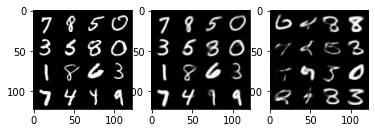

Iter: 06460/8000, Recon loss: 617.9207, KL div loss: 17.8367, Total loss: 635.7573
Iter: 06470/8000, Recon loss: 718.5768, KL div loss: 16.0995, Total loss: 734.6763
Iter: 06480/8000, Recon loss: 632.5876, KL div loss: 16.1047, Total loss: 648.6924
Iter: 06490/8000, Recon loss: 711.3013, KL div loss: 17.4675, Total loss: 728.7688
Iter: 06500/8000, Recon loss: 691.9514, KL div loss: 11.6219, Total loss: 703.5733


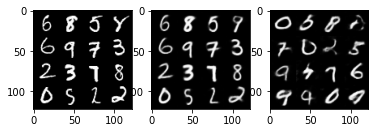

Iter: 06510/8000, Recon loss: 732.2974, KL div loss: 13.5960, Total loss: 745.8933
Iter: 06520/8000, Recon loss: 674.7165, KL div loss: 16.6067, Total loss: 691.3232
Iter: 06530/8000, Recon loss: 730.8235, KL div loss: 18.0571, Total loss: 748.8806
Iter: 06540/8000, Recon loss: 661.6146, KL div loss: 15.2825, Total loss: 676.8972
Iter: 06550/8000, Recon loss: 713.9813, KL div loss: 16.5803, Total loss: 730.5616


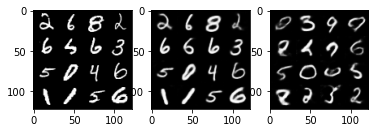

Iter: 06560/8000, Recon loss: 703.8801, KL div loss: 14.8408, Total loss: 718.7209
Iter: 06570/8000, Recon loss: 702.1713, KL div loss: 12.1018, Total loss: 714.2731
Iter: 06580/8000, Recon loss: 728.8997, KL div loss: 14.4898, Total loss: 743.3895
Iter: 06590/8000, Recon loss: 677.9971, KL div loss: 17.5864, Total loss: 695.5834
Iter: 06600/8000, Recon loss: 751.3751, KL div loss: 16.2566, Total loss: 767.6317


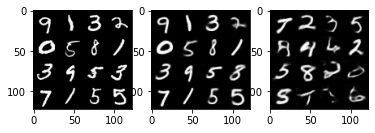

Iter: 06610/8000, Recon loss: 659.7228, KL div loss: 23.9644, Total loss: 683.6871
Iter: 06620/8000, Recon loss: 685.4496, KL div loss: 14.0415, Total loss: 699.4910
Iter: 06630/8000, Recon loss: 684.5601, KL div loss: 15.8256, Total loss: 700.3857
Iter: 06640/8000, Recon loss: 746.7363, KL div loss: 13.7180, Total loss: 760.4543
Iter: 06650/8000, Recon loss: 646.2097, KL div loss: 15.1828, Total loss: 661.3925


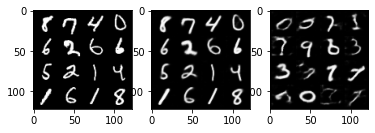

Iter: 06660/8000, Recon loss: 704.2402, KL div loss: 13.3664, Total loss: 717.6066
Iter: 06670/8000, Recon loss: 662.7616, KL div loss: 20.3999, Total loss: 683.1614
Iter: 06680/8000, Recon loss: 642.7966, KL div loss: 16.0933, Total loss: 658.8899
Iter: 06690/8000, Recon loss: 796.4878, KL div loss: 12.3378, Total loss: 808.8256
Iter: 06700/8000, Recon loss: 720.5374, KL div loss: 18.3008, Total loss: 738.8382


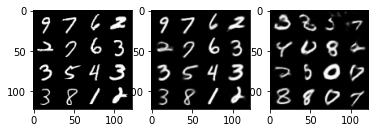

Iter: 06710/8000, Recon loss: 754.0677, KL div loss: 19.1324, Total loss: 773.2001
Iter: 06720/8000, Recon loss: 699.6476, KL div loss: 14.2188, Total loss: 713.8664
Iter: 06730/8000, Recon loss: 656.4577, KL div loss: 19.8123, Total loss: 676.2700
Iter: 06740/8000, Recon loss: 686.4730, KL div loss: 20.7980, Total loss: 707.2711
Iter: 06750/8000, Recon loss: 687.3377, KL div loss: 21.1486, Total loss: 708.4863


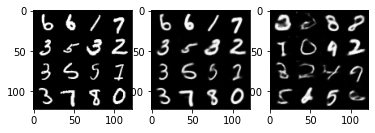

Iter: 06760/8000, Recon loss: 575.1449, KL div loss: 15.9813, Total loss: 591.1262
Iter: 06770/8000, Recon loss: 691.8076, KL div loss: 16.2155, Total loss: 708.0232
Iter: 06780/8000, Recon loss: 707.8521, KL div loss: 18.8207, Total loss: 726.6727
Iter: 06790/8000, Recon loss: 832.5805, KL div loss: 18.6107, Total loss: 851.1912
Iter: 06800/8000, Recon loss: 651.3068, KL div loss: 14.3860, Total loss: 665.6927


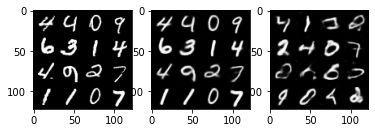

Iter: 06810/8000, Recon loss: 689.5665, KL div loss: 20.6850, Total loss: 710.2515
Iter: 06820/8000, Recon loss: 696.7047, KL div loss: 18.8994, Total loss: 715.6041
Iter: 06830/8000, Recon loss: 639.5162, KL div loss: 15.2797, Total loss: 654.7959
Iter: 06840/8000, Recon loss: 761.9681, KL div loss: 11.2251, Total loss: 773.1932
Iter: 06850/8000, Recon loss: 743.4349, KL div loss: 12.2971, Total loss: 755.7321


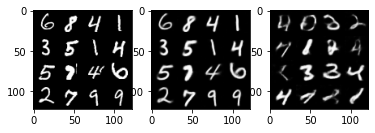

Iter: 06860/8000, Recon loss: 708.0061, KL div loss: 20.5006, Total loss: 728.5067
Iter: 06870/8000, Recon loss: 701.3290, KL div loss: 11.5509, Total loss: 712.8799
Iter: 06880/8000, Recon loss: 687.6475, KL div loss: 9.0471, Total loss: 696.6945
Iter: 06890/8000, Recon loss: 659.9876, KL div loss: 14.7637, Total loss: 674.7513
Iter: 06900/8000, Recon loss: 592.3021, KL div loss: 14.1893, Total loss: 606.4914


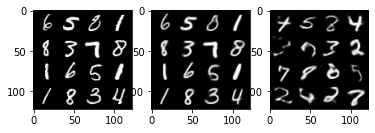

Iter: 06910/8000, Recon loss: 716.7081, KL div loss: 16.4816, Total loss: 733.1897
Iter: 06920/8000, Recon loss: 666.8807, KL div loss: 17.7593, Total loss: 684.6400
Iter: 06930/8000, Recon loss: 741.4222, KL div loss: 16.0550, Total loss: 757.4772
Iter: 06940/8000, Recon loss: 682.6708, KL div loss: 14.5268, Total loss: 697.1976
Iter: 06950/8000, Recon loss: 593.9182, KL div loss: 12.5275, Total loss: 606.4457


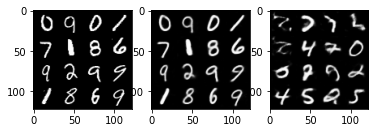

Iter: 06960/8000, Recon loss: 718.1799, KL div loss: 16.6522, Total loss: 734.8321
Iter: 06970/8000, Recon loss: 688.6132, KL div loss: 10.9558, Total loss: 699.5689
Iter: 06980/8000, Recon loss: 655.4977, KL div loss: 13.4786, Total loss: 668.9763
Iter: 06990/8000, Recon loss: 744.2697, KL div loss: 17.1942, Total loss: 761.4639
Iter: 07000/8000, Recon loss: 698.7276, KL div loss: 14.8962, Total loss: 713.6238


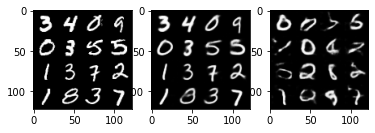

Iter: 07010/8000, Recon loss: 640.3350, KL div loss: 12.4397, Total loss: 652.7746
Iter: 07020/8000, Recon loss: 665.3090, KL div loss: 12.9094, Total loss: 678.2184
Iter: 07030/8000, Recon loss: 664.6517, KL div loss: 16.3429, Total loss: 680.9946
Iter: 07040/8000, Recon loss: 638.8427, KL div loss: 15.7035, Total loss: 654.5461
Iter: 07050/8000, Recon loss: 681.2529, KL div loss: 18.5408, Total loss: 699.7936


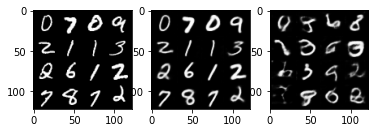

Iter: 07060/8000, Recon loss: 716.3118, KL div loss: 14.8320, Total loss: 731.1438
Iter: 07070/8000, Recon loss: 800.4542, KL div loss: 11.3977, Total loss: 811.8518
Iter: 07080/8000, Recon loss: 669.6606, KL div loss: 15.6465, Total loss: 685.3071
Iter: 07090/8000, Recon loss: 732.8964, KL div loss: 18.6244, Total loss: 751.5207
Iter: 07100/8000, Recon loss: 737.1765, KL div loss: 11.6731, Total loss: 748.8495


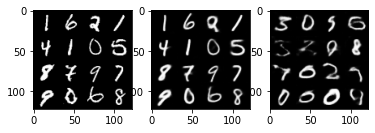

Iter: 07110/8000, Recon loss: 710.1008, KL div loss: 14.2608, Total loss: 724.3616
Iter: 07120/8000, Recon loss: 658.9948, KL div loss: 16.8064, Total loss: 675.8012
Iter: 07130/8000, Recon loss: 744.3387, KL div loss: 18.3364, Total loss: 762.6751
Iter: 07140/8000, Recon loss: 652.0054, KL div loss: 13.5587, Total loss: 665.5641
Iter: 07150/8000, Recon loss: 711.7776, KL div loss: 9.7139, Total loss: 721.4915


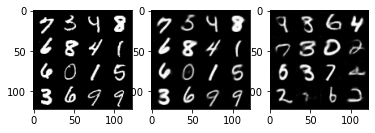

Iter: 07160/8000, Recon loss: 616.4546, KL div loss: 16.0950, Total loss: 632.5496
Iter: 07170/8000, Recon loss: 752.5139, KL div loss: 16.0595, Total loss: 768.5734
Iter: 07180/8000, Recon loss: 656.3547, KL div loss: 15.7822, Total loss: 672.1370
Iter: 07190/8000, Recon loss: 711.3238, KL div loss: 12.1862, Total loss: 723.5100
Iter: 07200/8000, Recon loss: 751.4449, KL div loss: 18.8683, Total loss: 770.3132


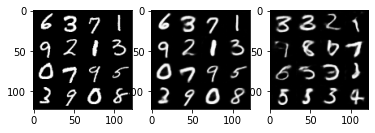

Iter: 07210/8000, Recon loss: 684.6734, KL div loss: 15.8115, Total loss: 700.4849
Iter: 07220/8000, Recon loss: 715.7739, KL div loss: 12.8698, Total loss: 728.6437
Iter: 07230/8000, Recon loss: 734.5363, KL div loss: 18.7723, Total loss: 753.3086
Iter: 07240/8000, Recon loss: 738.0405, KL div loss: 13.4278, Total loss: 751.4682
Iter: 07250/8000, Recon loss: 634.0161, KL div loss: 18.2782, Total loss: 652.2942


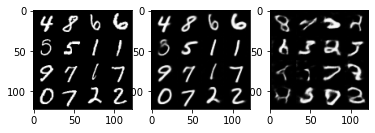

Iter: 07260/8000, Recon loss: 655.5760, KL div loss: 20.0233, Total loss: 675.5994
Iter: 07270/8000, Recon loss: 716.8609, KL div loss: 14.3042, Total loss: 731.1651
Iter: 07280/8000, Recon loss: 601.1227, KL div loss: 15.2671, Total loss: 616.3898
Iter: 07290/8000, Recon loss: 672.7020, KL div loss: 18.5187, Total loss: 691.2206
Iter: 07300/8000, Recon loss: 688.7380, KL div loss: 13.9088, Total loss: 702.6468


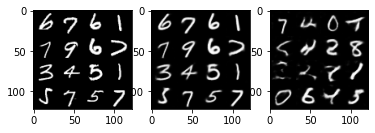

Iter: 07310/8000, Recon loss: 685.0513, KL div loss: 16.4480, Total loss: 701.4993
Iter: 07320/8000, Recon loss: 704.0941, KL div loss: 10.5101, Total loss: 714.6041
Iter: 07330/8000, Recon loss: 677.1653, KL div loss: 22.1383, Total loss: 699.3036
Iter: 07340/8000, Recon loss: 703.9729, KL div loss: 12.9137, Total loss: 716.8866
Iter: 07350/8000, Recon loss: 707.7871, KL div loss: 18.0813, Total loss: 725.8683


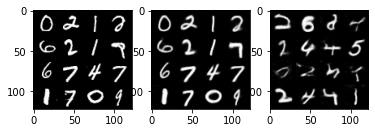

Iter: 07360/8000, Recon loss: 636.8655, KL div loss: 14.4103, Total loss: 651.2758
Iter: 07370/8000, Recon loss: 695.1699, KL div loss: 22.2033, Total loss: 717.3732
Iter: 07380/8000, Recon loss: 604.6122, KL div loss: 16.0271, Total loss: 620.6393
Iter: 07390/8000, Recon loss: 692.8885, KL div loss: 15.4143, Total loss: 708.3027
Iter: 07400/8000, Recon loss: 727.5032, KL div loss: 11.3664, Total loss: 738.8695


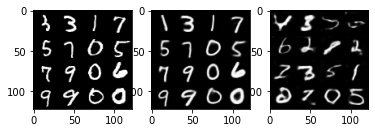

Iter: 07410/8000, Recon loss: 765.0854, KL div loss: 17.0585, Total loss: 782.1440
Iter: 07420/8000, Recon loss: 670.7902, KL div loss: 13.4703, Total loss: 684.2605
Iter: 07430/8000, Recon loss: 726.7485, KL div loss: 16.6251, Total loss: 743.3737
Iter: 07440/8000, Recon loss: 710.6062, KL div loss: 20.6539, Total loss: 731.2601
Iter: 07450/8000, Recon loss: 633.2732, KL div loss: 18.8812, Total loss: 652.1544


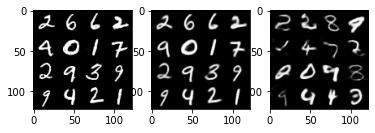

Iter: 07460/8000, Recon loss: 666.4471, KL div loss: 18.3595, Total loss: 684.8066
Iter: 07470/8000, Recon loss: 737.0712, KL div loss: 19.2042, Total loss: 756.2755
Iter: 07480/8000, Recon loss: 688.0163, KL div loss: 14.8551, Total loss: 702.8714
Iter: 07490/8000, Recon loss: 697.3405, KL div loss: 14.5982, Total loss: 711.9386
Iter: 07500/8000, Recon loss: 763.2178, KL div loss: 14.8688, Total loss: 778.0867


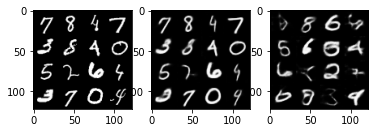

Iter: 07510/8000, Recon loss: 644.9348, KL div loss: 22.8429, Total loss: 667.7777
Iter: 07520/8000, Recon loss: 753.3500, KL div loss: 17.6467, Total loss: 770.9966
Iter: 07530/8000, Recon loss: 742.0913, KL div loss: 19.0039, Total loss: 761.0952
Iter: 07540/8000, Recon loss: 653.4257, KL div loss: 17.1406, Total loss: 670.5663
Iter: 07550/8000, Recon loss: 643.1219, KL div loss: 13.1155, Total loss: 656.2374


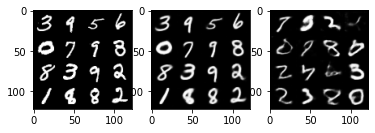

Iter: 07560/8000, Recon loss: 622.4796, KL div loss: 17.6059, Total loss: 640.0856
Iter: 07570/8000, Recon loss: 625.2441, KL div loss: 25.7065, Total loss: 650.9506
Iter: 07580/8000, Recon loss: 661.4769, KL div loss: 11.9383, Total loss: 673.4152
Iter: 07590/8000, Recon loss: 667.8992, KL div loss: 17.0381, Total loss: 684.9373
Iter: 07600/8000, Recon loss: 539.2592, KL div loss: 16.3058, Total loss: 555.5649


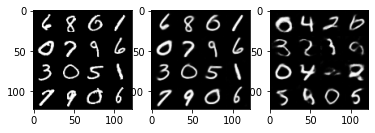

Iter: 07610/8000, Recon loss: 710.4333, KL div loss: 17.6780, Total loss: 728.1114
Iter: 07620/8000, Recon loss: 703.2753, KL div loss: 15.7616, Total loss: 719.0369
Iter: 07630/8000, Recon loss: 584.2782, KL div loss: 14.8687, Total loss: 599.1469
Iter: 07640/8000, Recon loss: 592.3554, KL div loss: 18.5961, Total loss: 610.9515
Iter: 07650/8000, Recon loss: 603.6042, KL div loss: 15.0150, Total loss: 618.6193


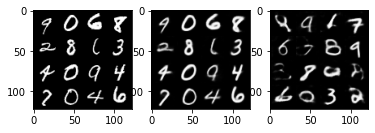

Iter: 07660/8000, Recon loss: 619.6902, KL div loss: 13.8373, Total loss: 633.5275
Iter: 07670/8000, Recon loss: 632.8522, KL div loss: 11.6375, Total loss: 644.4897
Iter: 07680/8000, Recon loss: 676.6879, KL div loss: 18.4608, Total loss: 695.1486
Iter: 07690/8000, Recon loss: 740.1902, KL div loss: 16.3540, Total loss: 756.5442
Iter: 07700/8000, Recon loss: 654.5540, KL div loss: 10.5120, Total loss: 665.0659


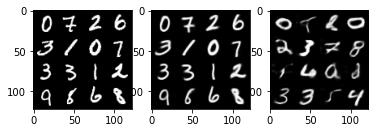

Iter: 07710/8000, Recon loss: 673.4128, KL div loss: 14.5628, Total loss: 687.9756
Iter: 07720/8000, Recon loss: 726.5416, KL div loss: 20.2797, Total loss: 746.8214
Iter: 07730/8000, Recon loss: 783.7188, KL div loss: 14.0432, Total loss: 797.7620
Iter: 07740/8000, Recon loss: 708.8105, KL div loss: 16.6395, Total loss: 725.4501
Iter: 07750/8000, Recon loss: 740.1871, KL div loss: 21.0040, Total loss: 761.1911


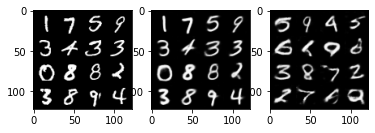

Iter: 07760/8000, Recon loss: 734.4815, KL div loss: 18.7356, Total loss: 753.2171
Iter: 07770/8000, Recon loss: 575.9497, KL div loss: 16.0978, Total loss: 592.0475
Iter: 07780/8000, Recon loss: 641.4523, KL div loss: 13.5615, Total loss: 655.0139
Iter: 07790/8000, Recon loss: 657.3671, KL div loss: 14.1072, Total loss: 671.4743
Iter: 07800/8000, Recon loss: 567.4487, KL div loss: 14.5223, Total loss: 581.9711


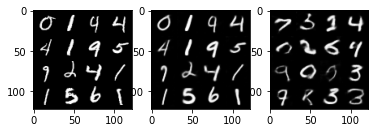

Iter: 07810/8000, Recon loss: 666.8683, KL div loss: 11.5409, Total loss: 678.4092
Iter: 07820/8000, Recon loss: 742.9345, KL div loss: 8.3486, Total loss: 751.2831
Iter: 07830/8000, Recon loss: 747.3821, KL div loss: 17.1310, Total loss: 764.5131
Iter: 07840/8000, Recon loss: 604.9218, KL div loss: 16.5670, Total loss: 621.4888
Iter: 07850/8000, Recon loss: 722.4359, KL div loss: 12.8368, Total loss: 735.2726


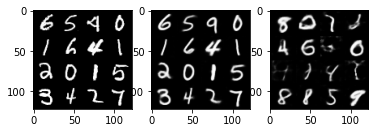

Iter: 07860/8000, Recon loss: 724.9840, KL div loss: 13.5385, Total loss: 738.5225
Iter: 07870/8000, Recon loss: 642.3341, KL div loss: 17.3872, Total loss: 659.7213
Iter: 07880/8000, Recon loss: 841.8993, KL div loss: 17.8770, Total loss: 859.7763
Iter: 07890/8000, Recon loss: 792.8538, KL div loss: 12.6359, Total loss: 805.4897
Iter: 07900/8000, Recon loss: 690.1743, KL div loss: 16.8987, Total loss: 707.0731


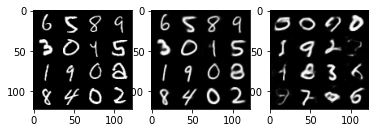

Iter: 07910/8000, Recon loss: 756.6840, KL div loss: 15.8751, Total loss: 772.5591
Iter: 07920/8000, Recon loss: 706.4785, KL div loss: 17.7820, Total loss: 724.2605
Iter: 07930/8000, Recon loss: 640.8406, KL div loss: 17.1893, Total loss: 658.0299
Iter: 07940/8000, Recon loss: 655.6803, KL div loss: 14.6731, Total loss: 670.3534
Iter: 07950/8000, Recon loss: 667.7609, KL div loss: 13.6858, Total loss: 681.4467


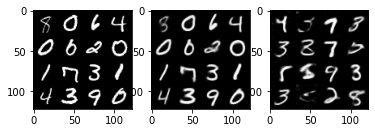

Iter: 07960/8000, Recon loss: 633.9670, KL div loss: 15.2617, Total loss: 649.2288
Iter: 07970/8000, Recon loss: 746.6270, KL div loss: 15.6092, Total loss: 762.2363
Iter: 07980/8000, Recon loss: 601.0170, KL div loss: 20.0848, Total loss: 621.1017
Iter: 07990/8000, Recon loss: 654.3455, KL div loss: 14.3056, Total loss: 668.6511
Iter: 08000/8000, Recon loss: 652.6342, KL div loss: 18.3852, Total loss: 671.0193


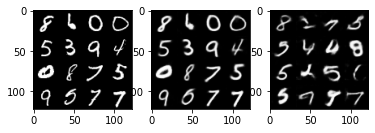

In [7]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_iter = iter(dataloader)

vae = VAE(img_dim, latent_dim).to(device)

optimizer = torch.optim.Adam(vae.parameters(), learning_rate)


for it in range(total_iter):
    try:
        imgs, _ = next(dataloader_iter)
    except:
        dataloader_iter = iter(dataloader)
        imgs, _ = next(dataloader_iter)
        
    imgs = imgs.view((-1, img_dim)).to(device)
    recon_imgs, mu, logvar = vae(imgs)
    
    ################ ToDo ################
#     recon_loss = F.binary_cross_entropy(recon_imgs, imgs, reduction='sum')
    recon_loss = F.mse_loss(recon_imgs, imgs, reduction = 'sum')
    kldiv_loss = -0.5*torch.sum(1 + logvar - pow(mu,2) - torch.exp(logvar))
    total_loss = (recon_loss + kldiv_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (it+1) % log_freq == 0:
        print("Iter: %05d/%d, Recon loss: %.4f, KL div loss: %.4f, Total loss: %.4f"%(it+1, total_iter,
                                                                                            recon_loss.data.item(),
                                                                                            kldiv_loss.data.item(),
                                                                                            total_loss.data.item()))
        
    if (it+1) % viz_freq == 0:
        with torch.no_grad():
            gen_imgs = vae.sample(16)
        org_imgs = make_grid(imgs[:16, :].view((16, 1, 28, 28)), nrow=4).permute(1, 2, 0).cpu().detach().numpy()
        plt.subplot(1, 3, 1)
        plt.imshow(org_imgs)
        recon_imgs = make_grid(recon_imgs[:16].view((16, 1, 28, 28)), nrow=4).permute(1, 2, 0).cpu().detach().numpy()
        plt.subplot(1, 3, 2)
        plt.imshow(recon_imgs)
        gen_imgs = make_grid(gen_imgs[:16].view((16, 1, 28, 28)), nrow=4).permute(1, 2, 0).cpu().detach().numpy()
        plt.subplot(1, 3, 3)
        plt.imshow(gen_imgs)
            
        plt.show()